In [ ]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageStat
from skimage import io, util, color, transform
from scipy.optimize import linear_sum_assignment
import sys
import cv2
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/FT_files.csv")
df

Plant_seg_results  \
0   /content/drive/MyDrive/images/net_5_zStack_pre...   
1   /content/drive/MyDrive/images/net_6_zStack_pre...   
2   /content/drive/MyDrive/images/net_7_zStack_pre...   
3   /content/drive/MyDrive/images/net_8_zStack_pre...   
4   /content/drive/MyDrive/images/net_9_zStack_pre...   
5   /content/drive/MyDrive/images/net_10_zStack_pr...   
6   /content/drive/MyDrive/images/net_11_zStack_pr...   
7   /content/drive/MyDrive/images/net_12_zStack_pr...   
8   /content/drive/MyDrive/images/net_13_zStack_pr...   
9   /content/drive/MyDrive/images/net_14_zStack_pr...   
10  /content/drive/MyDrive/images/net_15_zStack_pr...   
11  /content/drive/MyDrive/images/net_17_zStack_pr...   
12  /content/drive/MyDrive/images/net_18_zStack_pr...   
13  /content/drive/MyDrive/images/net_19_zStack_pr...   
14  /content/drive/MyDrive/images/net_20_zStack_pr...   
15  /content/drive/MyDrive/images/net_21_zStack_pr...   
16  /content/drive/MyDrive/images/net_23_zStack_pr...   

                                             Original  \
0    /content/drive/MyDrive/consolidated_images/5.jpg   
1    /content/drive/MyDrive/consolidated_images/6.png   
2    /content/drive/MyDrive/consolidated_images/7.png   
3    /content/drive/MyDrive/consolidated_images/8.png   
4    /content/drive/MyDrive/consolidated_images/9.jpg   
5   /content/drive/MyDrive/consolidated_images/10.png   
6   /content/drive/MyDrive/consolidated_images/11.jpg   
7   /content/drive/MyDrive/consolidated_images/12.png   
8   /content/drive/MyDrive/consolidated_images/13.jpg   
9   /content/drive/MyDrive/consolidated_images/14.jpg   
10  /content/drive/MyDrive/consolidated_images/15.png   
11  /content/drive/MyDrive/consolidated_images/17.jpg   
12  /content/drive/MyDrive/consolidated_images/18.png   
13  /content/drive/MyDrive/consolidated_images/19.png   
14  /content/drive/MyDrive/consolidated_images/20.png   
15  /content/drive/MyDrive/consolidated_images/21.png   
16  /content/drive/MyDrive/consolidated_images/23.png   

                                                Masks  \
0   /content/drive/MyDrive/Goundtruth_masks/mask_5...   
1   /content/drive/MyDrive/Goundtruth_masks/mask_6...   
2   /content/drive/MyDrive/Goundtruth_masks/mask_7...   
3   /content/drive/MyDrive/Goundtruth_masks/mask_8...   
4   /content/drive/MyDrive/Goundtruth_masks/mask_9...   
5   /content/drive/MyDrive/Goundtruth_masks/mask_1...   
6   /content/drive/MyDrive/Goundtruth_masks/mask_1...   
7   /content/drive/MyDrive/Goundtruth_masks/mask_1...   
8   /content/drive/MyDrive/Goundtruth_masks/mask_1...   
9   /content/drive/MyDrive/Goundtruth_masks/mask_1...   
10  /content/drive/MyDrive/Goundtruth_masks/mask_1...   
11  /content/drive/MyDrive/Goundtruth_masks/mask_1...   
12  /content/drive/MyDrive/Goundtruth_masks/mask_1...   
13  /content/drive/MyDrive/Goundtruth_masks/mask_1...   
14  /content/drive/MyDrive/Goundtruth_masks/mask_2...   
15  /content/drive/MyDrive/Goundtruth_masks/mask_2...   
16  /content/drive/MyDrive/Goundtruth_masks/mask_2...   

                                          mask_pickle  
0   /content/drive/MyDrive/mask_sam_filtered/masks...  
1   /content/drive/MyDrive/mask_sam_filtered/masks...  
2   /content/drive/MyDrive/mask_sam_filtered/masks...  
3   /content/drive/MyDrive/mask_sam_filtered/masks...  
4   /content/drive/MyDrive/mask_sam_filtered/masks...  
5   /content/drive/MyDrive/mask_sam_filtered/masks...  
6   /content/drive/MyDrive/mask_sam_filtered/masks...  
7   /content/drive/MyDrive/mask_sam_filtered/masks...  
8   /content/drive/MyDrive/mask_sam_filtered/masks...  
9   /content/drive/MyDrive/mask_sam_filtered/masks...  
10  /content/drive/MyDrive/mask_sam_filtered/masks...  
11  /content/drive/MyDrive/mask_sam_filtered/masks...  
12  /content/drive/MyDrive/mask_sam_filtered/masks...  
13  /content/drive/MyDrive/mask_sam_filtered/masks...  
14  /content/drive/MyDrive/mask_sam_filtered/masks...  
15  /content/drive/MyDrive/mask_sam_filtered/masks...  
16 

Extracting SAM weights

In [ ]:
import os

HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-kspo2pfv
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-kspo2pfv
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=de7e406d56e7909b5b1150bf7ff16d1a4d9a4372d0b584c215b21e214e896c3f
  Stored in directory: /tmp/pip-ephem-wheel-cache-wb3eoj8o/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [ ]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.3 MB/s eta 0:00:00


In [ ]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [ ]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [ ]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [ ]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
for i in range(19):
  resized = []
  with open(f'/content/drive/MyDrive/finetuned_sam_masks/masks{i}.pkl', 'rb') as file:
    masks = pickle.load(file)

  for mask in masks:
    mask2 = cv2.resize(np.uint8(mask), (1024, 1024))
    resized.append(mask2)

  with open(f'/content/drive/MyDrive/masks_sam_ft_resized/masks{i}.pkl', 'wb') as file:
    pickle.dump(resized, file)

In [ ]:
# import supervision as sv
# import pickle
# for i, row in df.iterrows():
#   image = io.imread(row['Original'])
#   if image.shape[2] > 3:
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#   sam_result = mask_generator.generate(image)
#   masks = [
#     mask['segmentation']
#     for mask
#     in sorted(sam_result, key=lambda x: x['area'], reverse=True)
#   ]
#   with open(f"/content/drive/MyDrive/mask_sam_pickle/masks{i}.pkl", 'wb') as file:
#     pickle.dump(masks, file)

In [ ]:
# for i, row in df.iterrows():
#   image_tiff = io.imread(row['Plant_seg_results'])
#   image = image_tiff[0]
#   unique_labels = np.unique(image)
#   masks2 = []
#   for label in unique_labels:
#       # Create a mask for the current label
#       mask1 = (image == label).astype(np.uint8)
#       masks2.append(mask1)
#   with open(f"/content/drive/MyDrive/mask_ps_pickle/masks{i}.pkl", 'wb') as file:
#     pickle.dump(masks2, file)

In [ ]:
import numpy as np
from scipy import ndimage

def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

In [ ]:
# with open(f'/content/drive/MyDrive/masks_sam_resized/masks2.pkl', 'rb') as file:
#   masks = pickle.load(file)
# resized = []
# for mask in masks:

#   mask2 = cv2.resize(np.uint8(mask), (1024, 1024))
#   resized.append(mask2)
#   # rotated_img = transform.rotate(mask, angle=-90)
#   # rotated.append(rotated_img)

# with open(f'/content/drive/MyDrive/masks_sam_resized/masks2.pkl', 'wb') as file:
#   pickle.dump(resized, file)
# for i in range(len(mask_list_sam[2])):
#     # Rotate the image by 90 degrees to the right
#     rotated_img = transform.rotate(mask_list_sam[2][i], angle=-90)
#     # Update the original image in the list with the rotated image
#     mask_list_sam[2][i] = rotated_img

In [ ]:
# import re
# areas_ps = []
# centers_ps = []
# mask_list_ps = []
# folder_path = '/content/drive/MyDrive/masks_ps_resized/'
# # Loop through files in the folder
# for filename in os.listdir(folder_path):
#     if filename.endswith(".pkl"):  # Adjust file extensions as needed
#         image_path = os.path.join(folder_path, filename)
#         image_number = re.search(r'(\d+)', os.path.splitext(filename)[0]).group(1)
#     areas2 = []
#     with open(image_path, 'rb') as file:
#       masks2 = pickle.load(file)
#     for mask in masks2:
#         # Label objects in the binary mask
#         labeled_mask, num_features = ndimage.label(mask)

#         # Calculate the area of each labeled object
#         object_areas = ndimage.sum(mask, labeled_mask, range(1, num_features + 1))

#         # Append the areas to the areas list
#         areas2.append(np.sum(object_areas))

#     centers2 = []

#     for i in range(len(masks2)):
#       center = ndimage.measurements.center_of_mass(masks2[i])
#       centers2.append(center)

#     areas_ps.append(areas2)
#     centers_ps.append(centers2)
#     mask_list_ps.append(masks2)

<ipython-input-13-2be3e922c774>:27: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  center = ndimage.measurements.center_of_mass(masks2[i])


In [ ]:
# areas_sam = []
# centers_sam = []
# mask_list_sam = []
# folder_path = '/content/drive/MyDrive/masks_sam_resized/'
# # Loop through files in the folder
# for filename in os.listdir(folder_path):
#     if filename.endswith(".pkl"):  # Adjust file extensions as needed
#         image_path = os.path.join(folder_path, filename)
#         image_number = re.search(r'(\d+)', os.path.splitext(filename)[0]).group(1)
#     areas = []
#     with open(image_path, 'rb') as file:
#       masks = pickle.load(file)
#     for mask in masks:
#         # Label objects in the binary mask
#         labeled_mask, num_features = ndimage.label(mask)

#         # Calculate the area of each labeled object
#         object_areas = ndimage.sum(mask, labeled_mask, range(1, num_features + 1))

#         # Append the areas to the areas list
#         areas.append(np.sum(object_areas))

#     centers = []
#     for i in range(len(masks)):
#       center = ndimage.measurements.center_of_mass(masks[i])
#       centers.append(center)

#     areas_sam.append(areas)
#     centers_sam.append(centers)
#     mask_list_sam.append(masks)

<ipython-input-14-045250f1aae7>:25: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  center = ndimage.measurements.center_of_mass(masks[i])


In [ ]:
areas_ps = []
centers_ps = []
mask_list_ps = []
for i in range(19):
  areas2 = []
  with open(f'/content/drive/MyDrive/masks_ps_resized/masks{i}.pkl', 'rb') as file:
    masks2 = pickle.load(file)
  for mask in masks2:
      # Label objects in the binary mask
      labeled_mask, num_features = ndimage.label(mask)

      # Calculate the area of each labeled object
      object_areas = ndimage.sum(mask, labeled_mask, range(1, num_features + 1))

      # Append the areas to the areas list
      areas2.append(np.sum(object_areas))

  # mean_area = np.mean(areas2)
  # std_dev_area = np.std(areas2)

  # # Calculate the threshold (mean + 3 * standard deviation)
  # threshold = mean_area + 3 * std_dev_area

  # # Find areas that exceed the threshold
  # areas_above_threshold = [area for area in areas2 if area >= threshold]

  # # Print or use the areas above the threshold
  # print("Areas above the threshold:", areas_above_threshold)

  # Create a filtered list of masks
  # filtered_mask_list2 = []
  # filtered_areas_list2 = []
  centers2 = []
  # Iterate through the masks and areas, keeping only those below the threshold
  # for mask, area in zip(masks2, areas2):
  #     # if area <= threshold:
  #         filtered_mask_list2.append(mask)
  #         filtered_areas_list2.append(area)

  for i in range(len(masks2)):
    center = ndimage.measurements.center_of_mass(masks2[i])
    centers2.append(center)

  areas_ps.append(areas2)
  centers_ps.append(centers2)
  mask_list_ps.append(masks2)

<ipython-input-86-bd9933aa9a88>:41: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  center = ndimage.measurements.center_of_mass(masks2[i])


In [ ]:
areas_sam = []
centers_sam = []
mask_list_sam = []
for i in range(19):
  # remove redundant masks
  areas = []
  with open(f'/content/drive/MyDrive/masks_sam_resized/masks{i}.pkl', 'rb') as file:
    masks = pickle.load(file)
  for mask in masks:
      # Label objects in the binary mask
      labeled_mask, num_features = ndimage.label(mask)

      # Calculate the area of each labeled object
      object_areas = ndimage.sum(mask, labeled_mask, range(1, num_features + 1))

      # Append the areas to the areas list
      areas.append(np.sum(object_areas))

#   if i == 2:
#     for m in range(len(masks)):
#         # Rotate the image by 90 degrees to the right
#         mask = transform.rotate(masks[m], angle=-90)
#         masks[m] = mask

  # mean_area = np.mean(areas)
  # std_dev_area = np.std(areas)

  # # Calculate the threshold (mean + 3 * standard deviation)
  # # threshold = mean_area + 2 * std_dev_area
  # threshold = mean_area + std_dev_area
  # # Find areas that exceed the threshold
  # areas_above_threshold = [area for area in areas if area >= threshold]

  # # Print or use the areas above the threshold
  # print("Areas above the threshold:", areas_above_threshold)

  # # Create a filtered list of masks
  # filtered_mask_list = []
  # filtered_areas_list = []

  # # Iterate through the masks and areas, keeping only those below the threshold
  # for mask, area in zip(masks, areas):
  #     if area <= threshold:
  #         filtered_mask_list.append(mask)
  #         filtered_areas_list.append(area)
  centers = []
  for i in range(len(masks)):
    center = ndimage.measurements.center_of_mass(masks[i])
    centers.append(center)

  areas_sam.append(areas)
  centers_sam.append(centers)
  mask_list_sam.append(masks)

<ipython-input-87-2a2c201affb3>:48: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  center = ndimage.measurements.center_of_mass(masks[i])


In [ ]:
import supervision as sv
sv.plot_images_grid(
    images=mask_list_sam[13],
    # grid_size=(16, int(len(masks) / 16)),
    grid_size= (16, 16),
    size=(30, 30)
)

In [ ]:
import supervision as sv
sv.plot_images_grid(
    images=mask_list_ps[13],
    # grid_size=(16, int(len(masks) / 16)),
    grid_size= (16, 16),
    size=(30, 30)
)

In [ ]:
# for i in range(len(df)):

# for center in centers_ps[2]:
#   for mask, k in zip(mask_list_sam[2], range(len(mask_list_sam[2]))):
#     if mask[int(center[1]), int(center[0])] == 1:
#       print(k)
#     else:
#       continue


In [ ]:
import math

def euclidean_distance(point1, point2):
    """
    Calculate the Euclidean distance between two points in n-dimensional space.

    Args:
        point1 (tuple or list): Coordinates of the first point.
        point2 (tuple or list): Coordinates of the second point.

    Returns:
        float: Euclidean distance between the two points.
    """
    if len(point1) != len(point2):
        raise ValueError("Both points must have the same number of dimensions.")

    squared_distance = sum((p1 - p2) ** 2 for p1, p2 in zip(point1, point2))
    distance = math.sqrt(squared_distance)
    return distance


In [ ]:
distances = []
for i in range(19):
  distance = []
  for center in centers_sam[i]:
    dist = []
    for center2 in centers_ps[i]:
      dist.append(euclidean_distance(center, center2))
    distance.append(dist)
  distances.append(distance)

In [ ]:
map_list = []
for i in range(19):
  fist_mapping = {}
  for outer_index, inner_list in enumerate(distances[i]):
      # Use list comprehension to get the indices of the 5 minimum values
      indices_of_min_values = sorted(range(len(inner_list)), key=lambda i: inner_list[i])[:5]

      # Store the result in the dictionary
      fist_mapping[outer_index] = indices_of_min_values

  map_list.append(fist_mapping)

In [ ]:
iou_matrix_list = []
for i in range(19):
  iou_matrix_sam = np.zeros((0, 5))
  # mask mapping wrt SAM results
  for key, values in map_list[i].items():
    iou_score = []
    for value in values:
      iou = calculate_iou(mask_list_sam[i][key], mask_list_ps[i][value])
      iou_score.append(iou)
    iou_matrix_sam = np.vstack((iou_matrix_sam, iou_score))

  iou_matrix_list.append(iou_matrix_sam)

In [ ]:
fin_map_list = []
fin_iou_list = []
for i in range(19):
  max_values = []
  max_indices = []

  final_mapping = {}
  final_iou_sam = []
  # Loop through the rows of the result_matrix
  for row in iou_matrix_list[i]:
      # Find the maximum value and its index in the current row
      max_value = np.max(row)
      max_index = np.argmax(row)
      # Append the maximum value and its index to the respective lists
      max_values.append(max_value)
      max_indices.append(max_index)
  k = 0
  for idx, max, value in zip(max_indices, max_values, map_list[i].values()):
    final_mapping[k] = value[idx]
    final_iou_sam.append(max)
    k = k+1
  fin_map_list.append(final_mapping)
  fin_iou_list.append(final_iou_sam)


In [ ]:
fil_map_list = fin_map_list

for i in range(18):

    for id, iou in enumerate(fin_iou_list[i]):
      fil_map_list[i][id] = (fil_map_list[i][id], iou)


for i in range(18):
    # Create a dictionary to store the maximum IOU score for each value
    max_iou_dict = {}

    # Iterate through the dictionary and update max_iou_dict with the highest IOU for each value
    for key, value in fil_map_list[i].items():
        current_iou = value[1]
        id = value[0]
        if value[0] in max_iou_dict:
            if current_iou > max_iou_dict[value[0]][1]:
                max_iou_dict[value[0]] = (key, current_iou)
        else:
            max_iou_dict[value[0]] = (key, current_iou)

    # Update fil_map_list with only the key-value pairs with the highest IOU for each value
    fil_map_list[i] = {max_iou_dict[key][0]: key for key in max_iou_dict}

In [ ]:
iou_scores_filtered = []
for i in range(len(fil_map_list)):
    # Check if fil_map_list[i] is not empty before accessing keys
    if fil_map_list[i]:
        filtered_iou_scores = [fin_iou_list[i][idx_1] for idx_1 in fil_map_list[i].keys()]
        iou_scores_filtered.append(filtered_iou_scores)
    else:
        # Handle empty dictionaries (e.g., append an empty list or default value)
        iou_scores_filtered.append([])  # Example: append an empty list

In [ ]:
fil_map_list

[{0: 8,
  1: 15,
  2: 17,
  3: 13,
  4: 5,
  6: 11,
  7: 135,
  9: 9,
  10: 7,
  12: 10,
  14: 278,
  15: 19,
  17: 277,
  18: 21,
  19: 29,
  20: 272,
  21: 262,
  22: 292,
  23: 216,
  24: 230,
  25: 283,
  27: 81,
  28: 165,
  29: 276,
  30: 4,
  31: 249,
  32: 31,
  33: 40,
  34: 28,
  35: 34,
  36: 291,
  37: 44,
  38: 37,
  39: 266,
  40: 26,
  41: 6,
  42: 23,
  43: 261,
  44: 267,
  45: 45,
  46: 248,
  47: 12,
  48: 16,
  49: 22,
  50: 27,
  51: 0,
  52: 154,
  53: 3,
  54: 178,
  55: 259,
  56: 33,
  57: 2,
  58: 215,
  60: 253,
  61: 38,
  62: 52,
  63: 251,
  64: 155,
  65: 100,
  66: 142,
  68: 85,
  69: 117,
  73: 114,
  74: 58,
  75: 43,
  76: 39,
  77: 32,
  78: 35,
  79: 36,
  80: 25,
  81: 24,
  82: 47,
  83: 50,
  84: 53,
  85: 56,
  86: 55,
  87: 54,
  88: 51,
  89: 57,
  90: 59,
  91: 60,
  92: 68,
  93: 76,
  94: 63,
  95: 77,
  96: 48,
  97: 42,
  98: 30,
  99: 84,
  101: 64,
  102: 61,
  103: 62,
  104: 67,
  105: 65,
  106: 66,
  107: 69,
  108: 71,
  109: 74,


/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


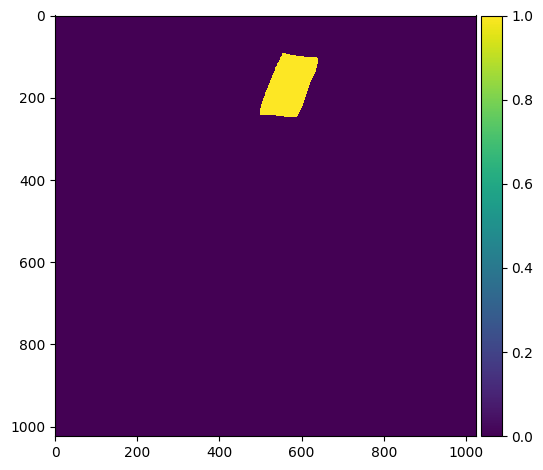

In [ ]:
io.imshow(mask_list_sam[11][0])

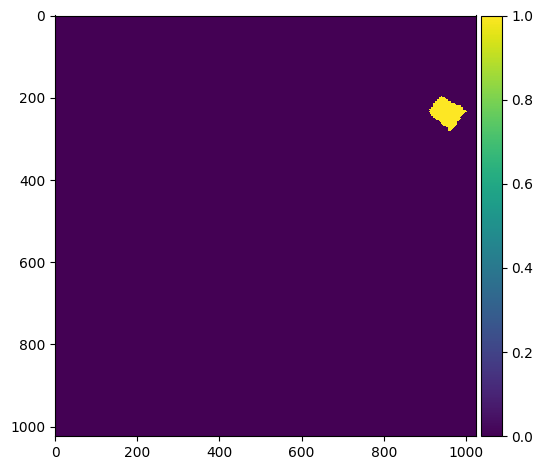

In [ ]:
io.imshow(mask_list_ps[11][5])

In [ ]:
fil_map_list[13]

{0: 15,
 2: 14,
 3: 13,
 5: 3,
 6: 33,
 7: 26,
 8: 32,
 9: 31,
 11: 39,
 12: 37,
 14: 40,
 15: 27,
 16: 38,
 17: 34,
 18: 28,
 22: 41,
 23: 17,
 24: 2,
 28: 36,
 31: 29,
 33: 4,
 36: 35,
 39: 5,
 41: 0,
 44: 8,
 51: 24,
 52: 23,
 60: 21,
 62: 30,
 79: 7,
 85: 20,
 88: 6,
 89: 10,
 94: 19,
 109: 9,
 126: 22,
 141: 12,
 150: 25,
 161: 11,
 170: 1}

In [ ]:
iou_scores_filtered[13]

[0.706390977443609,
 0.5623865519690632,
 0.4733216819163154,
 0.7555296856810244,
 0.7888324873096447,
 0.7936003390548845,
 0.7566483748417053,
 0.777919863597613,
 0.7358409916648857,
 0.643397654180855,
 0.6726398601398601,
 0.7452309236947792,
 0.57421875,
 0.32782337302046005,
 0.3803979366249079,
 0.6656700190269095,
 0.4697058250535749,
 0.38750796685787126,
 0.3659965173341776,
 0.22398091934084996,
 0.7304029304029304,
 0.3036417322834646,
 0.7223618090452262,
 0.2172241445597847,
 0.31594546532305867,
 0.7386958591147073,
 0.37915742793791574,
 0.3782812931749102,
 0.3944575471698113,
 0.3655541561712846,
 0.2648143594787313,
 0.1908108108108108,
 0.49709864603481624,
 0.21098459477561957,
 0.2844767844767845,
 0.131945889698231,
 0.5738341968911918,
 0.4317503392130258,
 0.2880672268907563,
 0.1003616636528029]

In [ ]:
for i in range(19):
  print(np.mean(iou_scores_filtered[i]))


0.6877116343749142
0.7318441266931351
0.807674398610277
0.7203489031898153
0.6597981677517836
0.7758198892150631
0.07436985241804811
0.6752019815988761
0.5517519007041851
0.5860022925923831
0.6087006791739112
0.1267746913580247
0.6447334031650571
0.48317268939647134
0.18096563608906416
0.36079904593352435
0.379990595905003
0.3939859557333975
0.6743371724285057


In [ ]:
# Calculate mean IOU scores for each sublist in iou_scores_filtered
mean_iou_scores = [np.mean(scores) for scores in iou_scores_filtered]

# Create a DataFrame with mean IOU scores
df_mean_iou = pd.DataFrame({'Mean_IOU': mean_iou_scores})

# Save DataFrame to an Excel file
excel_file_path = '/content/drive/MyDrive/results_iou_scores/mean_iou_scores_public_images.xlsx'
df_mean_iou.to_excel(excel_file_path, index=False)

print(f"Mean IOU scores saved to {excel_file_path}")

Mean IOU scores saved to /content/drive/MyDrive/results_iou_scores/mean_iou_scores_public_images.xlsx


In [ ]:
# centers_sam = []
# for ind, row in df.iterrows():
#   with open(f'/content/drive/MyDrive/mask_sam_pickle/masks{ind}.pkl', 'rb') as file:
#     masks = pickle.load(file)
#   centers = []
#   for i in range(len(masks)):
#     center = ndimage.measurements.center_of_mass(masks[i])
#     centers.append(center)
#   centers_sam.append(centers)

<ipython-input-14-7df80a69c4d7>:7: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  center = ndimage.measurements.center_of_mass(masks[i])


In [ ]:
for i, row in df.iterrows():

  with open(f'/content/drive/MyDrive/mask_sam_pickle/masks{i}.pkl', 'rb') as file:
    masks = pickle.load(file)
  with open(f'/content/drive/MyDrive/mask_ps_pickle/masks{i}.pkl', 'rb') as file:
    masks2 = pickle.load(file)
  iou_matrix_sam = np.zeros((len(masks), len(masks2)))
  # mask mapping wrt SAM results
  for i, pred_mask in enumerate(masks):
      for j, gt_mask in enumerate(masks2):
          iou_matrix_sam[i, j] = calculate_iou(pred_mask, gt_mask)

  mask_mapping_sam = {}
  for i in range(len(masks)):
    max_index = np.unravel_index(np.argmax(iou_matrix_sam[i]), iou_matrix_sam[i].shape)
    mask_mapping_sam[i] = max_index[0]

  iou_matrix_ps = np.zeros((len(masks2), len(masks)))

  for i, gt_mask in enumerate(masks2):
      for j, pred_mask in enumerate(masks):
          iou_matrix_ps[i, j] = calculate_iou(pred_mask, gt_mask)

  mask_mapping_ps = {}
  for i in range(len(masks2)):
    max_index = np.unravel_index(np.argmax(iou_matrix_ps[i]), iou_matrix_ps[i].shape)
    mask_mapping_ps[i] = max_index[0]

  mappings_final = {}
  for k, v in mask_mapping_sam.items():
    if mask_mapping_ps[v] == k:
        mappings_final[k] = v

  matched_iou_scores_fin = []

  for pred_index in mappings_final.keys():
      iou_score = iou_matrix_sam[pred_index, mappings_final[pred_index]]
      matched_iou_scores_fin.append(iou_score)

  with open(f"/content/drive/MyDrive/iou_lists_pickle/matched_iou_scores_fin{i}.pkl", 'wb') as file:
    pickle.dump(matched_iou_scores_fin, file)

  final_iou_score_list = []
  final_iou_score_list.append(np.mean(matched_iou_scores_fin))


In [ ]:
matched_iou_scores_fin

In [ ]:
df['iou_scores'] = final_iou_score_list

Generating masks using SAM

In [ ]:
import supervision as sv
sam_result = mask_generator.generate(image)

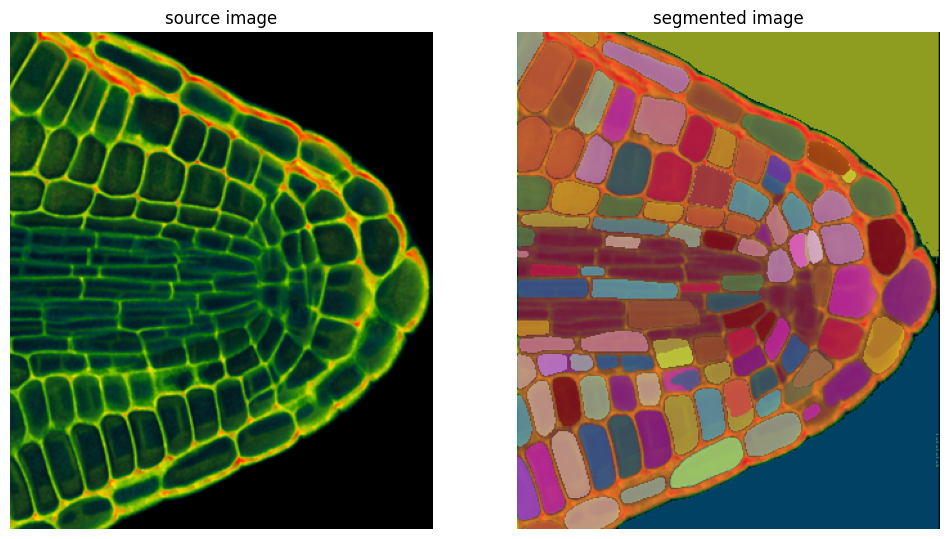

In [ ]:
mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)

sv.plot_images_grid(
    images=[image, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image'])

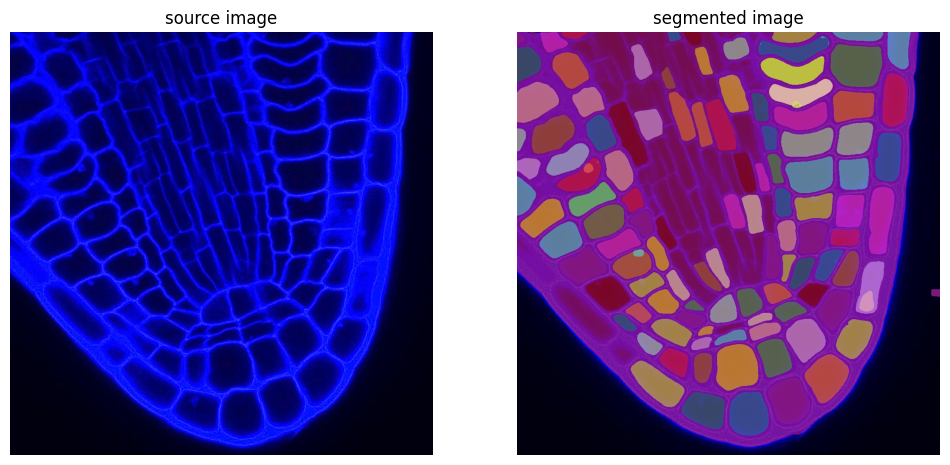

In [ ]:
mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)

sv.plot_images_grid(
    images=[image, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image'])

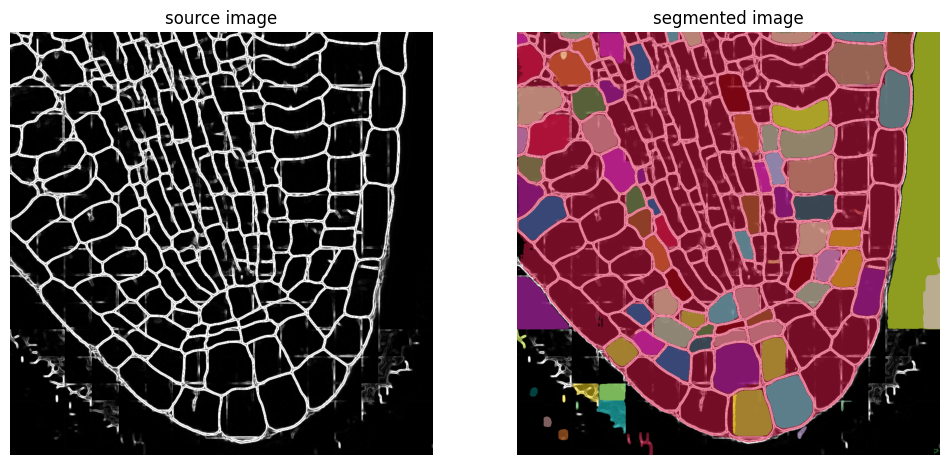

In [ ]:
mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=sobel1.copy(), detections=detections)

sv.plot_images_grid(
    images=[sobel1, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image'])

In [ ]:
io.imsave('annotated_img.png', annotated_image)

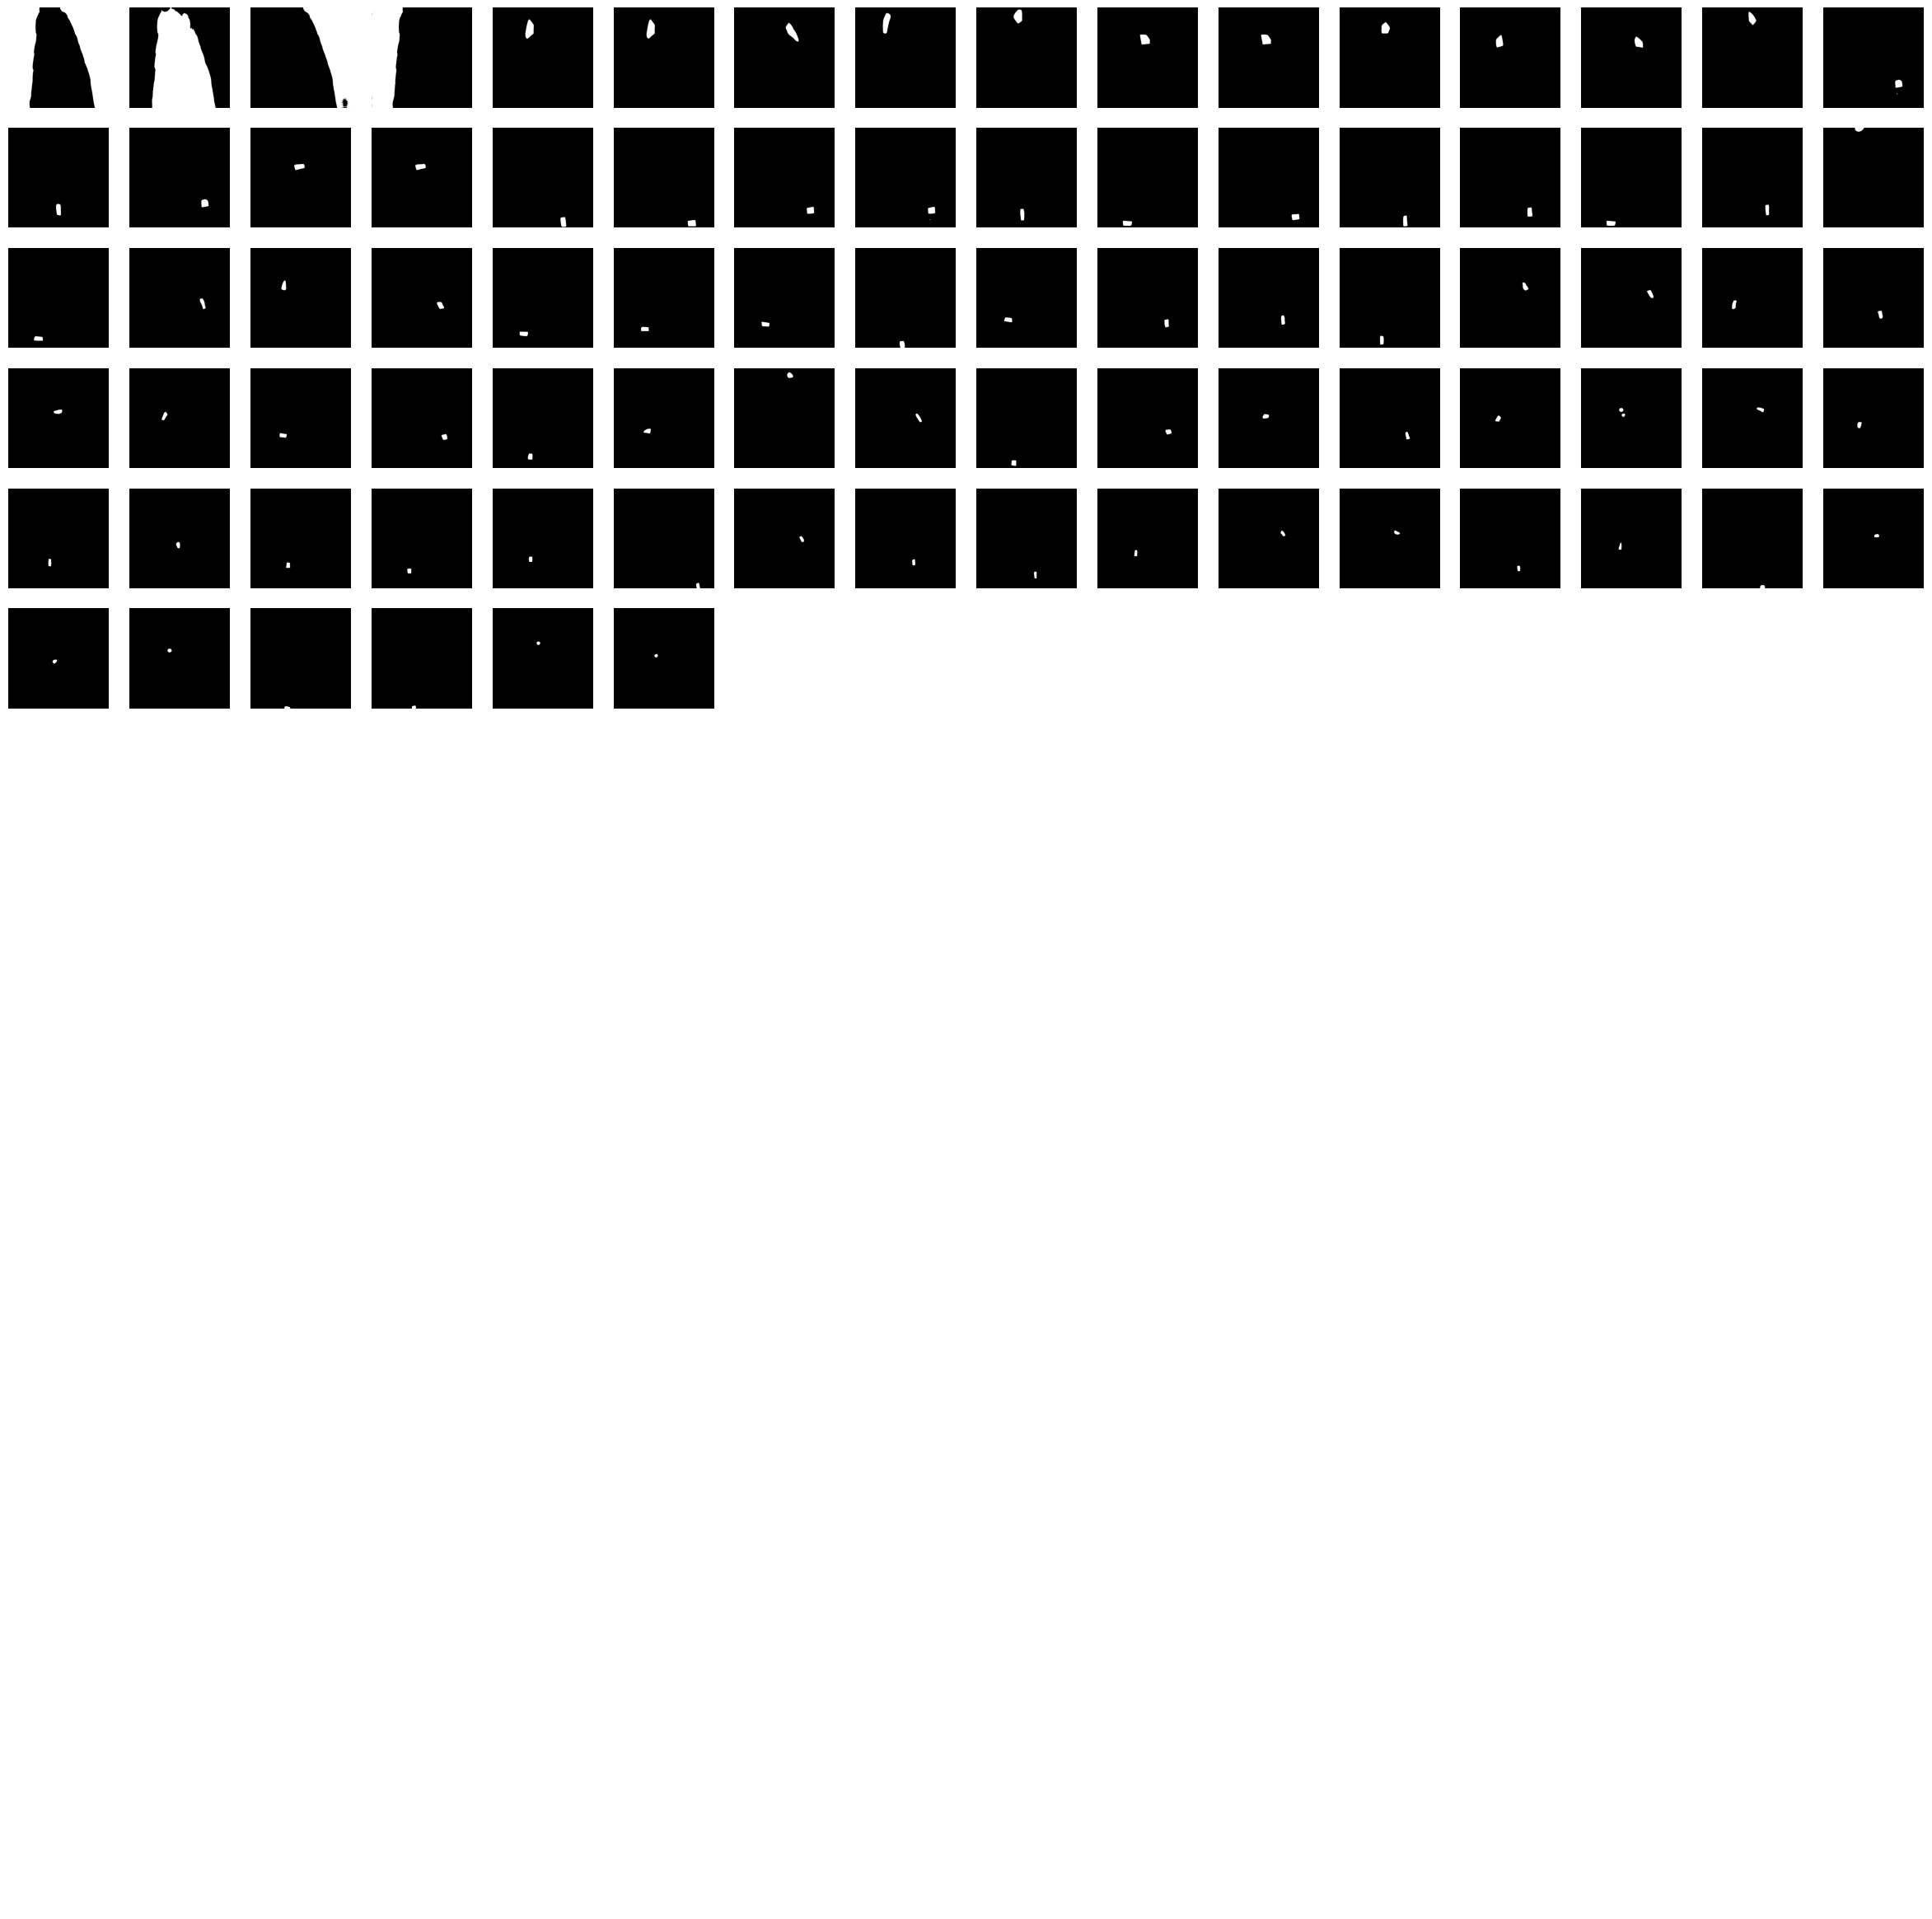

In [ ]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    # grid_size=(16, int(len(masks) / 16)),
    grid_size= (16, 16),
    size=(30, 30)
)

Prompt based predictions

In [ ]:
mask_predictor = SamPredictor(sam)

In [ ]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
# widget.image = encode_image("/content/weights/annotated_img.jpg")
widget.image = encode_image("/content/weights/annotated_img.jpg")
widget

FileNotFoundError: ignored

In [ ]:
widget.bboxes

[{'x': 64, 'y': 1, 'width': 21, 'height': 30, 'label': ''},
 {'x': 58, 'y': 103, 'width': 15, 'height': 25, 'label': ''}]

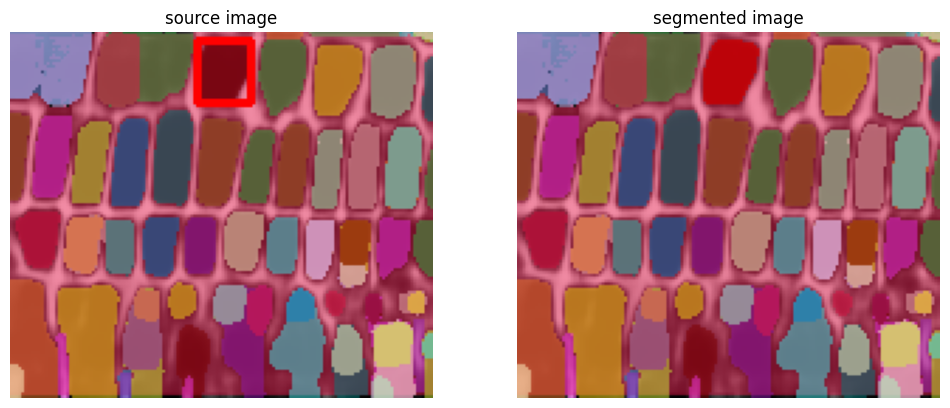

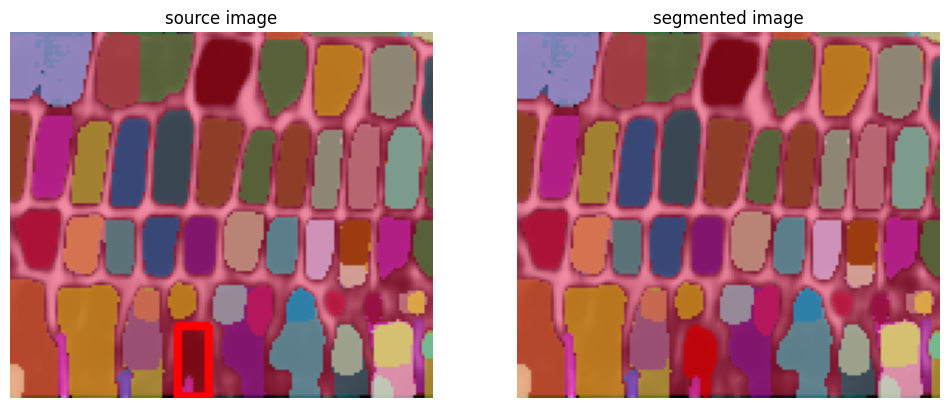

In [ ]:
# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}
for i in range(len(widget.bboxes)):
  box = widget.bboxes[i] if widget.bboxes else default_box
  box = np.array([
      box['x'],
      box['y'],
      box['x'] + box['width'],
      box['y'] + box['height']
  ])
  mask_predictor.set_image(annotated_image)

  masks, scores, logits = mask_predictor.predict(
      box=box,
      multimask_output=False
  )
  box_annotator = sv.BoxAnnotator(color=sv.Color.red())
  mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

  detections = sv.Detections(
      xyxy=sv.mask_to_xyxy(masks=masks),
      mask=masks
  )
  detections = detections[detections.area == np.max(detections.area)]

  source_image = box_annotator.annotate(scene=annotated_image.copy(), detections=detections, skip_label=True)
  segmented_image = mask_annotator.annotate(scene=annotated_image.copy(), detections=detections)

  sv.plot_images_grid(
      images=[source_image, segmented_image],
      grid_size=(1, 2),
      titles=['source image', 'segmented image']
  )

In [ ]:
# mask_predictor.set_image(annotated_image)

# masks, scores, logits = mask_predictor.predict(
#     box=box,
#     multimask_output=False
# )

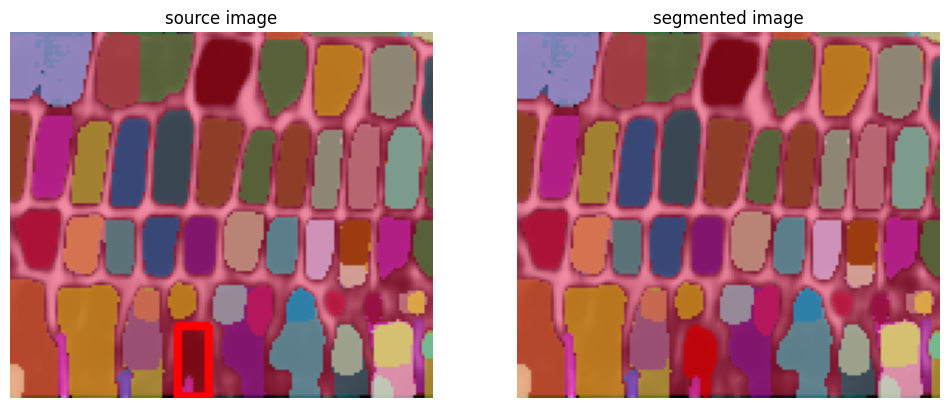

In [ ]:
# box_annotator = sv.BoxAnnotator(color=sv.Color.red())
# mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

# detections = sv.Detections(
#     xyxy=sv.mask_to_xyxy(masks=masks),
#     mask=masks
# )
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=annotated_image.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=annotated_image.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

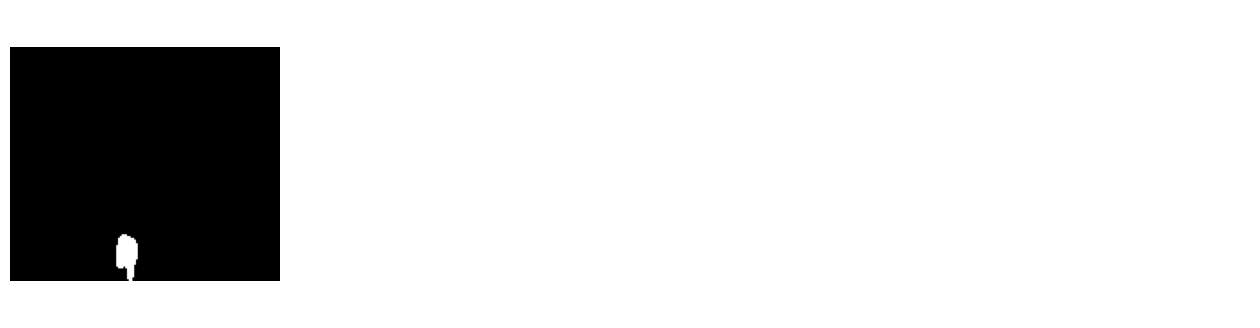

In [ ]:
import supervision as v

sv.plot_images_grid(
    images=masks,
    grid_size=(1, 4),
    size=(16, 4)
)

Windowing technique

In [ ]:
# Define patch size (e.g., 128x128 pixels)
patch_size = (500, 500)

# Calculate the number of patches in both dimensions
num_patches_x = image1.shape[1] // patch_size[1]
num_patches_y = image1.shape[0] // patch_size[0]

# Create an empty list to store the patches
patches = []

# Iterate through the image and extract non-overlapping patches
for i in range(num_patches_y):
    for j in range(num_patches_x):
        y_start = i * patch_size[0]
        y_end = (i + 1) * patch_size[0]
        x_start = j * patch_size[1]
        x_end = (j + 1) * patch_size[1]

        patch = image1[y_start:y_end, x_start:x_end, :]
        patches.append(patch)

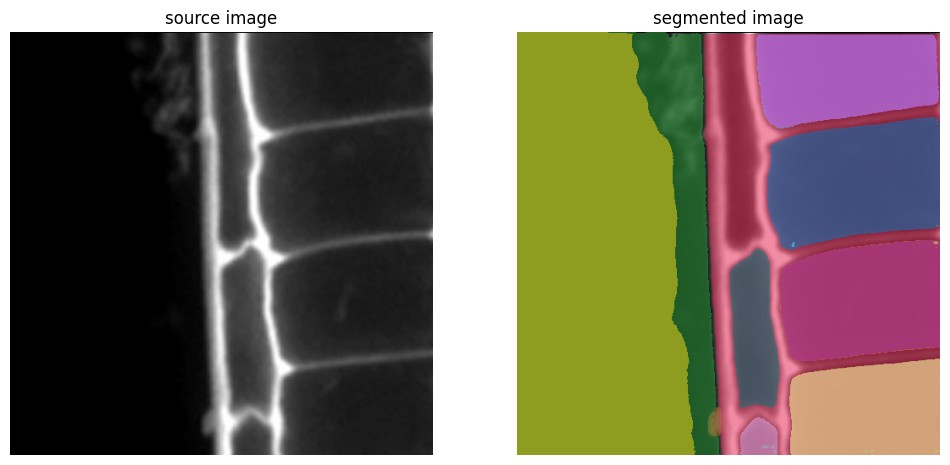

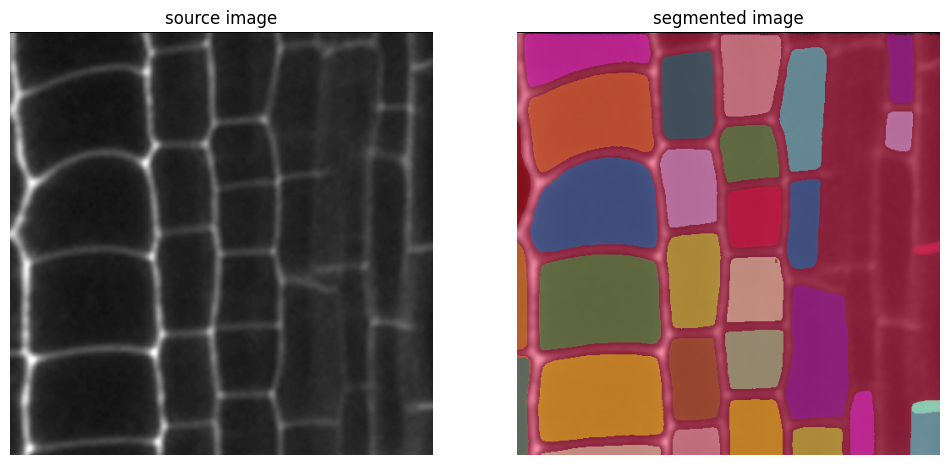

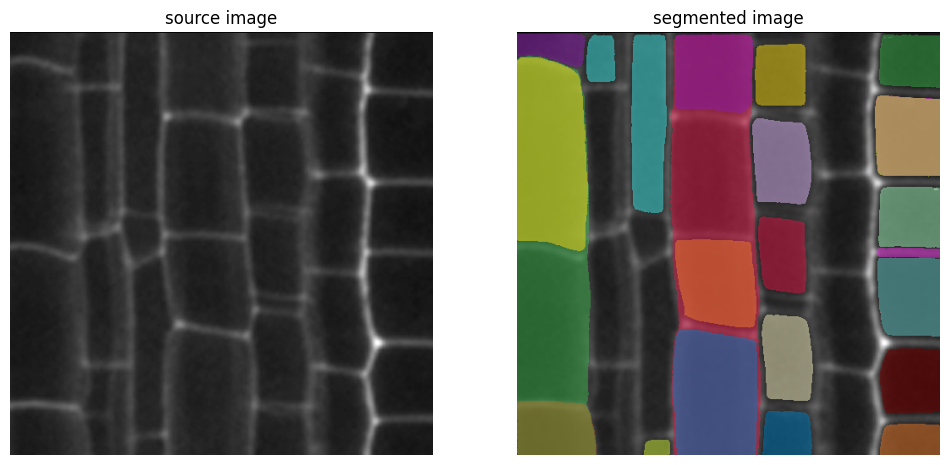

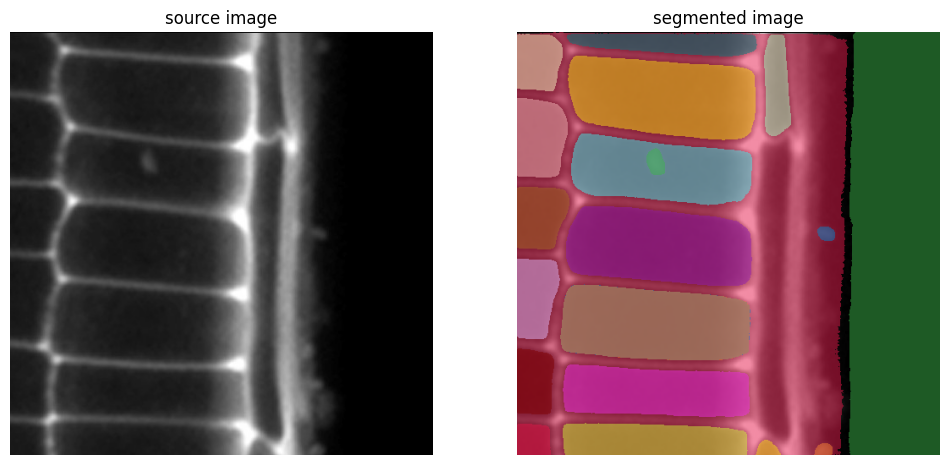

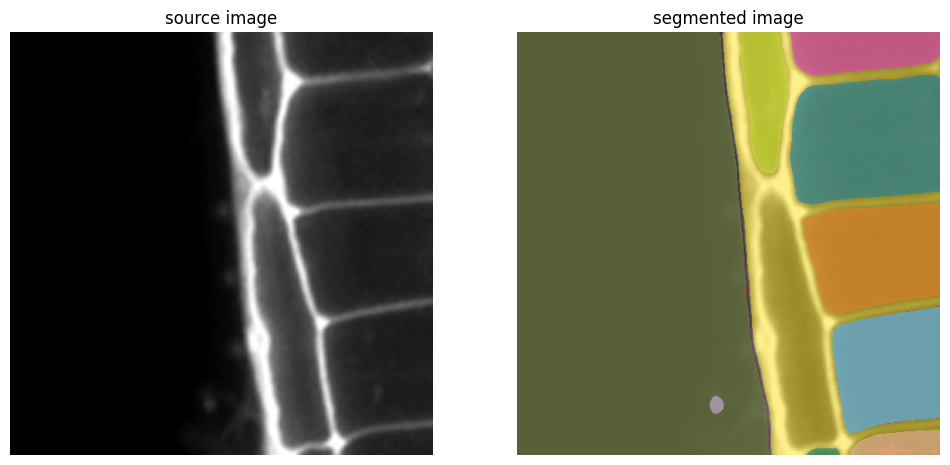

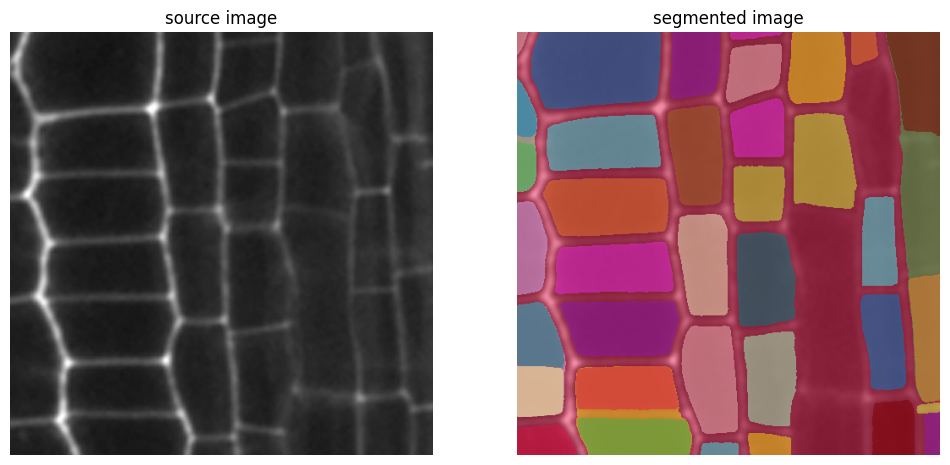

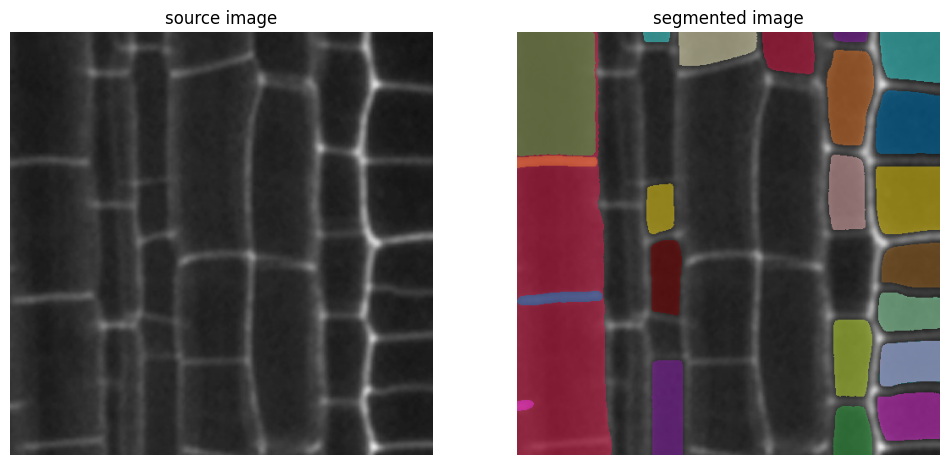

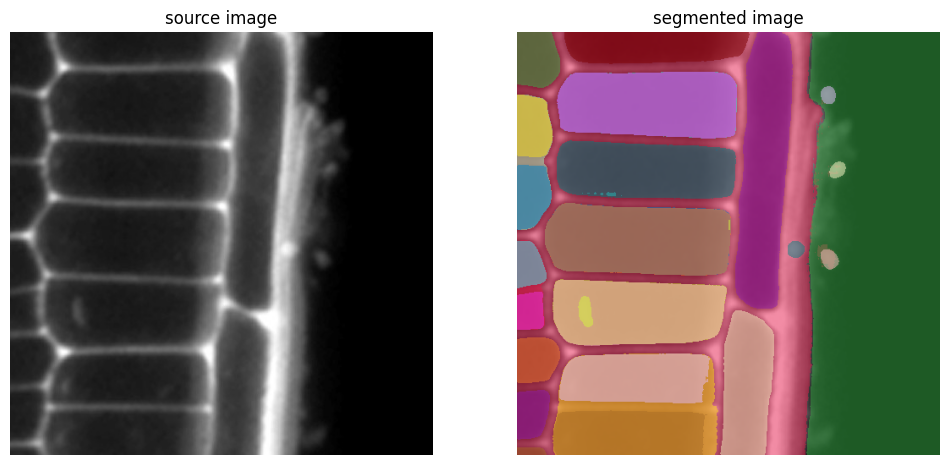

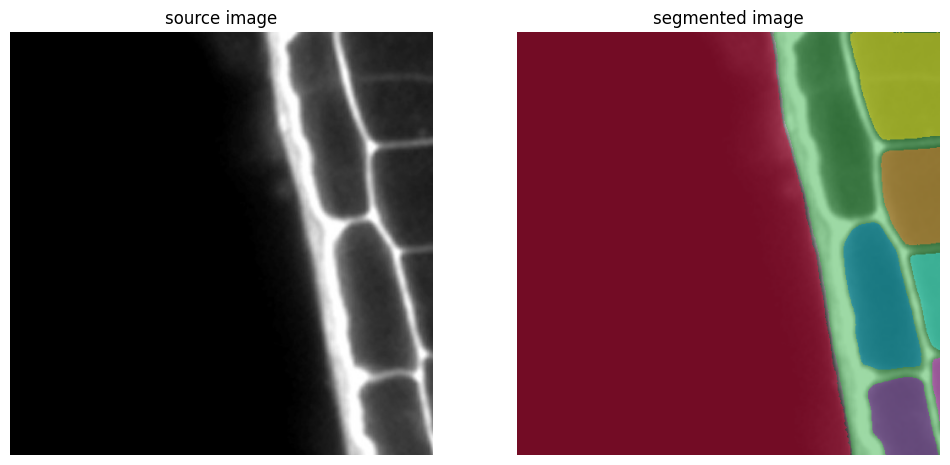

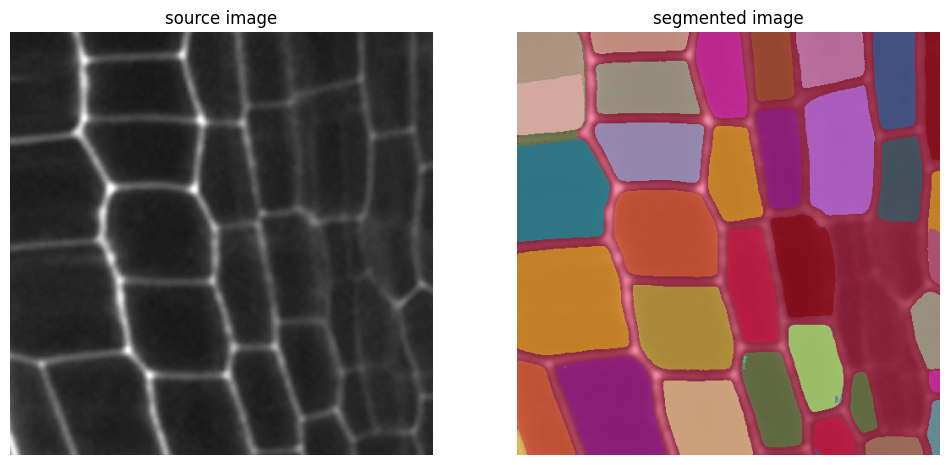

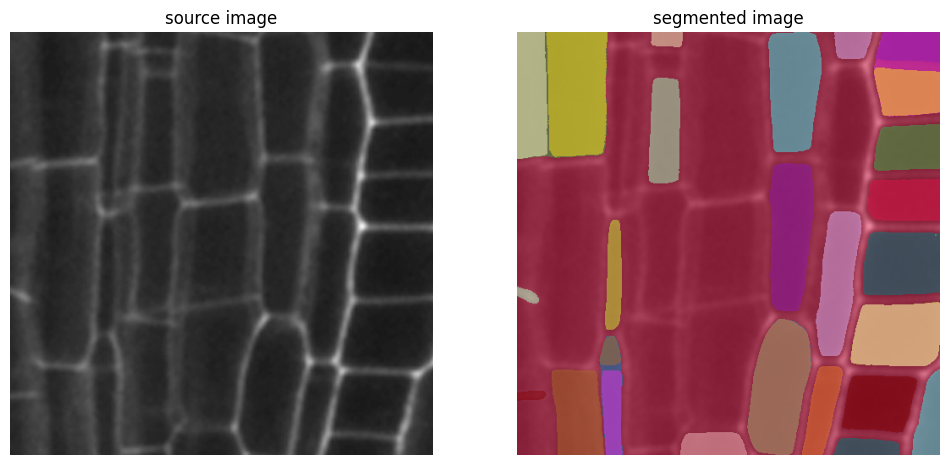

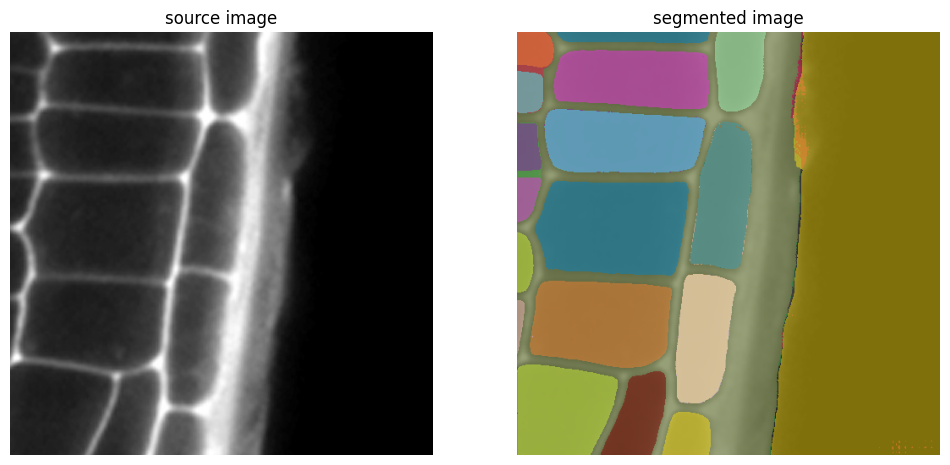

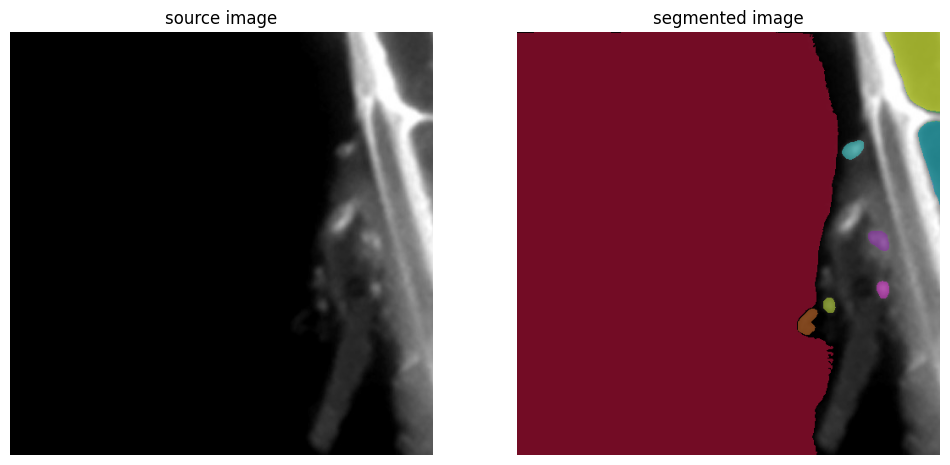

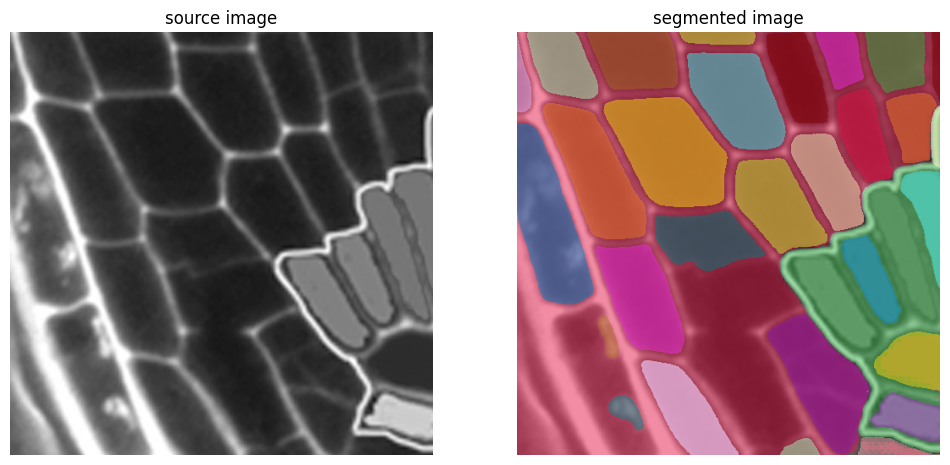

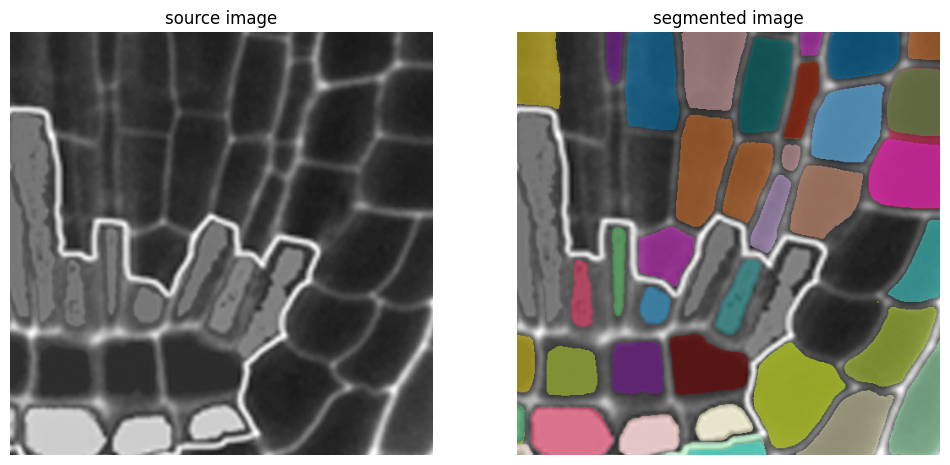

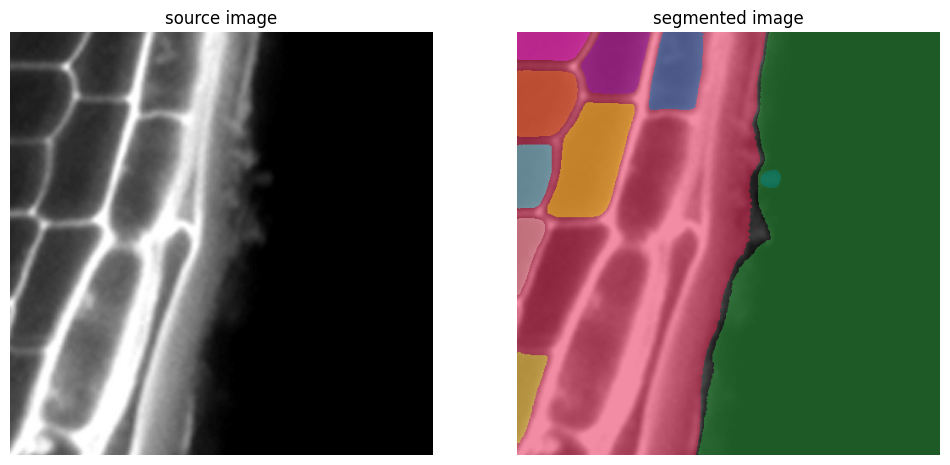

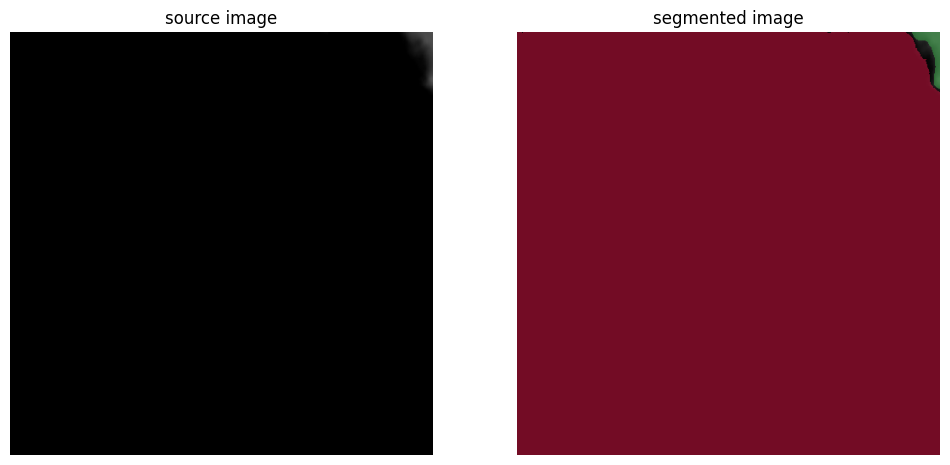

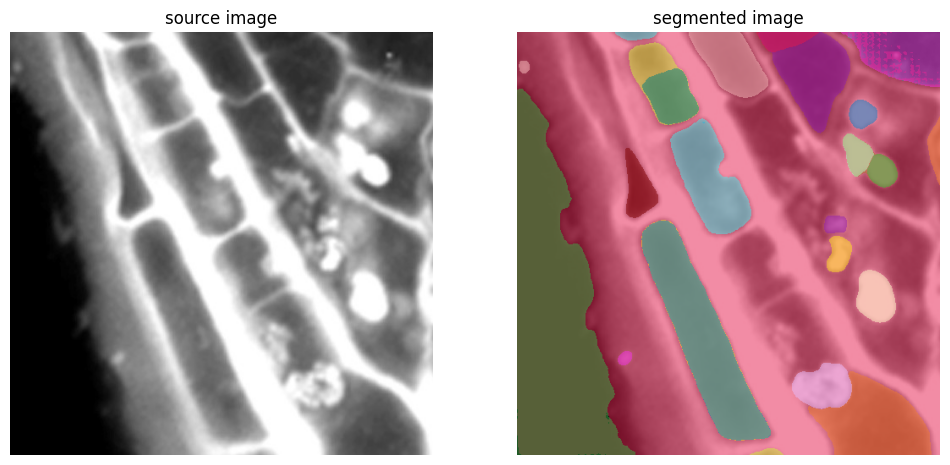

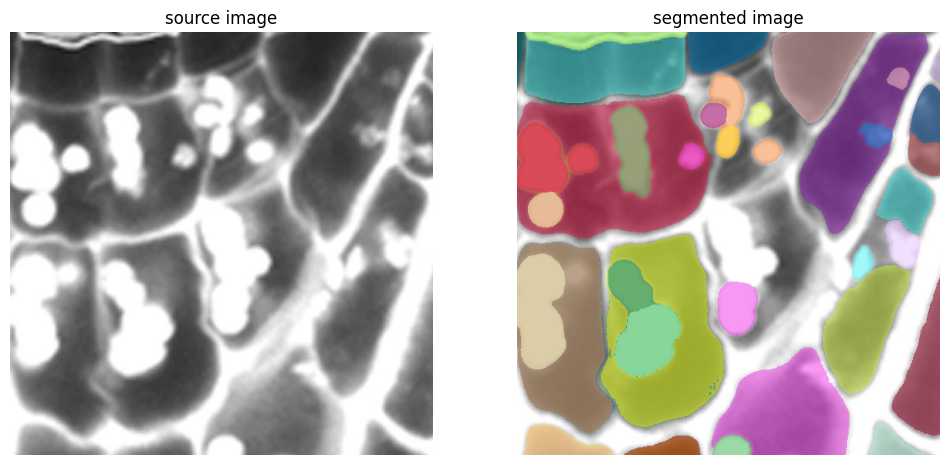

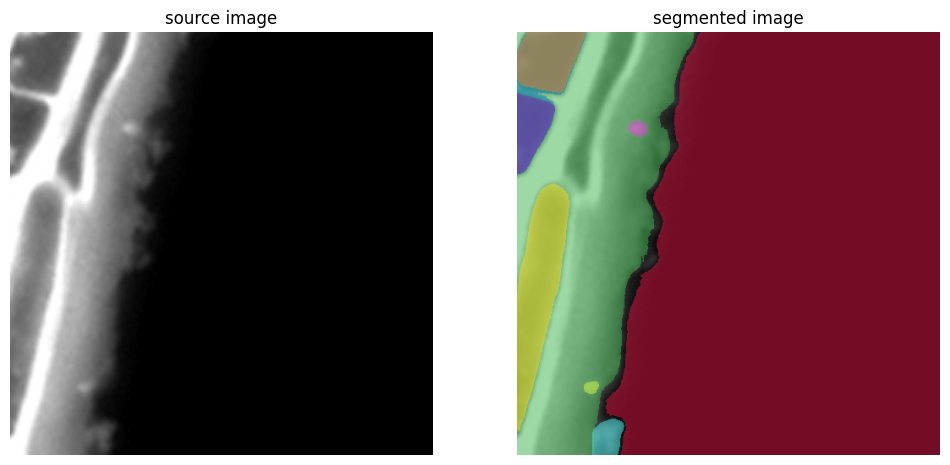

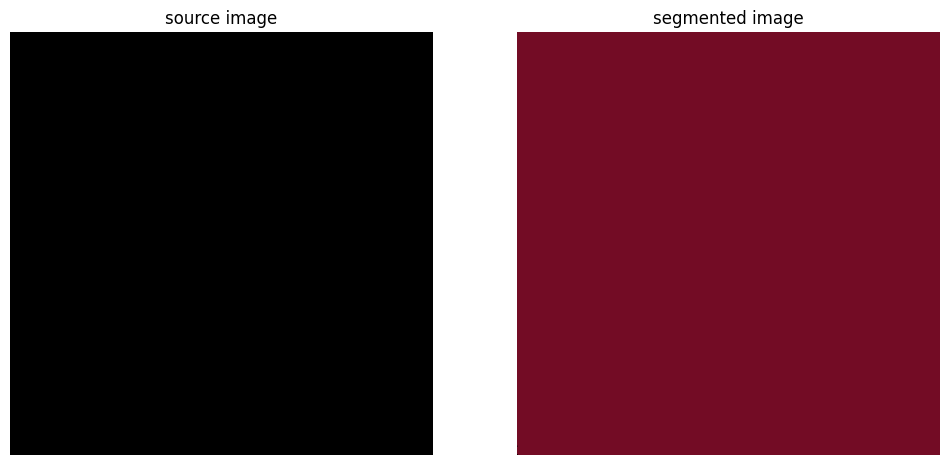

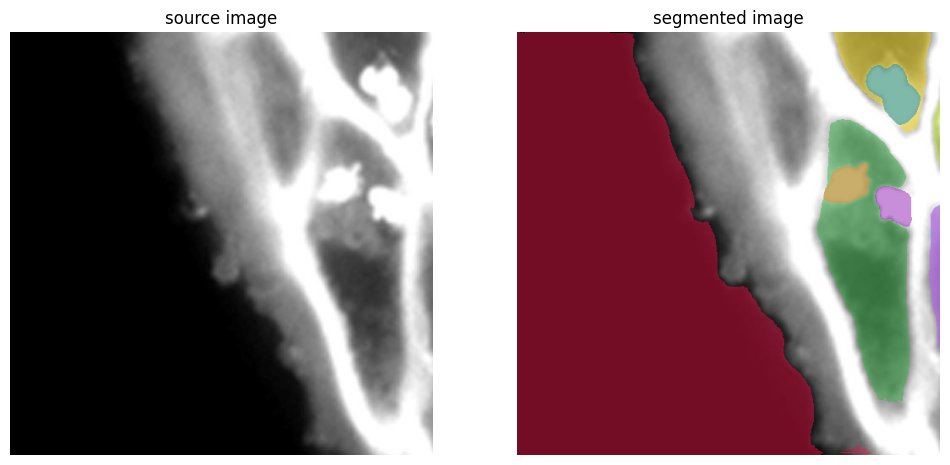

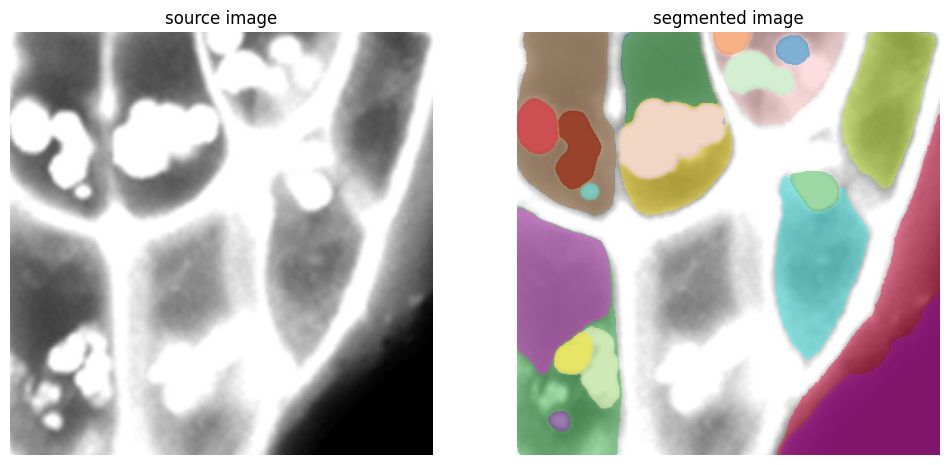

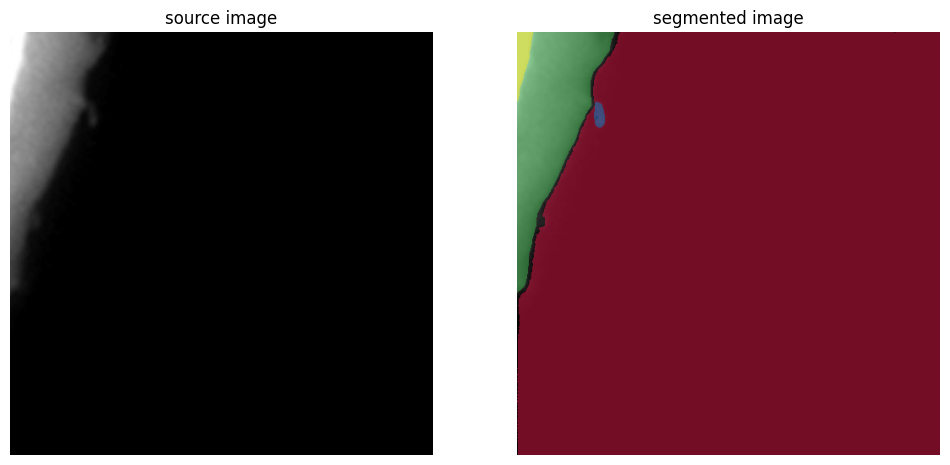

In [ ]:
image_patches = []
for img in patches:

  sam_result = mask_generator.generate(img)
  mask_annotator = sv.MaskAnnotator()

  detections = sv.Detections.from_sam(sam_result=sam_result)

  annotated_image = mask_annotator.annotate(scene=img.copy(), detections=detections)

  sv.plot_images_grid(
      images=[img, annotated_image],
      grid_size=(1, 2),
      titles=['source image', 'segmented image']
  )
  image_patches.append(annotated_image)

In [ ]:
# Create an empty array to store the reconstructed image
reconstructed_image = np.zeros((image1.shape[0], image1.shape[1], 3), dtype=np.uint8)

# Iterate through the patches and place them in the correct positions
patch_index = 0
for i in range(num_patches_y):
    for j in range(num_patches_x):
        y_start = i * patch_size[0]
        y_end = (i + 1) * patch_size[0]
        x_start = j * patch_size[1]
        x_end = (j + 1) * patch_size[1]

        patch = image_patches[patch_index]

        # Place the patch in the reconstructed image
        reconstructed_image[y_start:y_end, x_start:x_end, :] = patch

        patch_index += 1

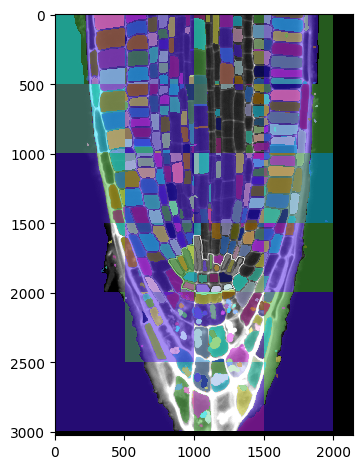

In [ ]:
io.imshow(reconstructed_image)

Plantseg results for comparison

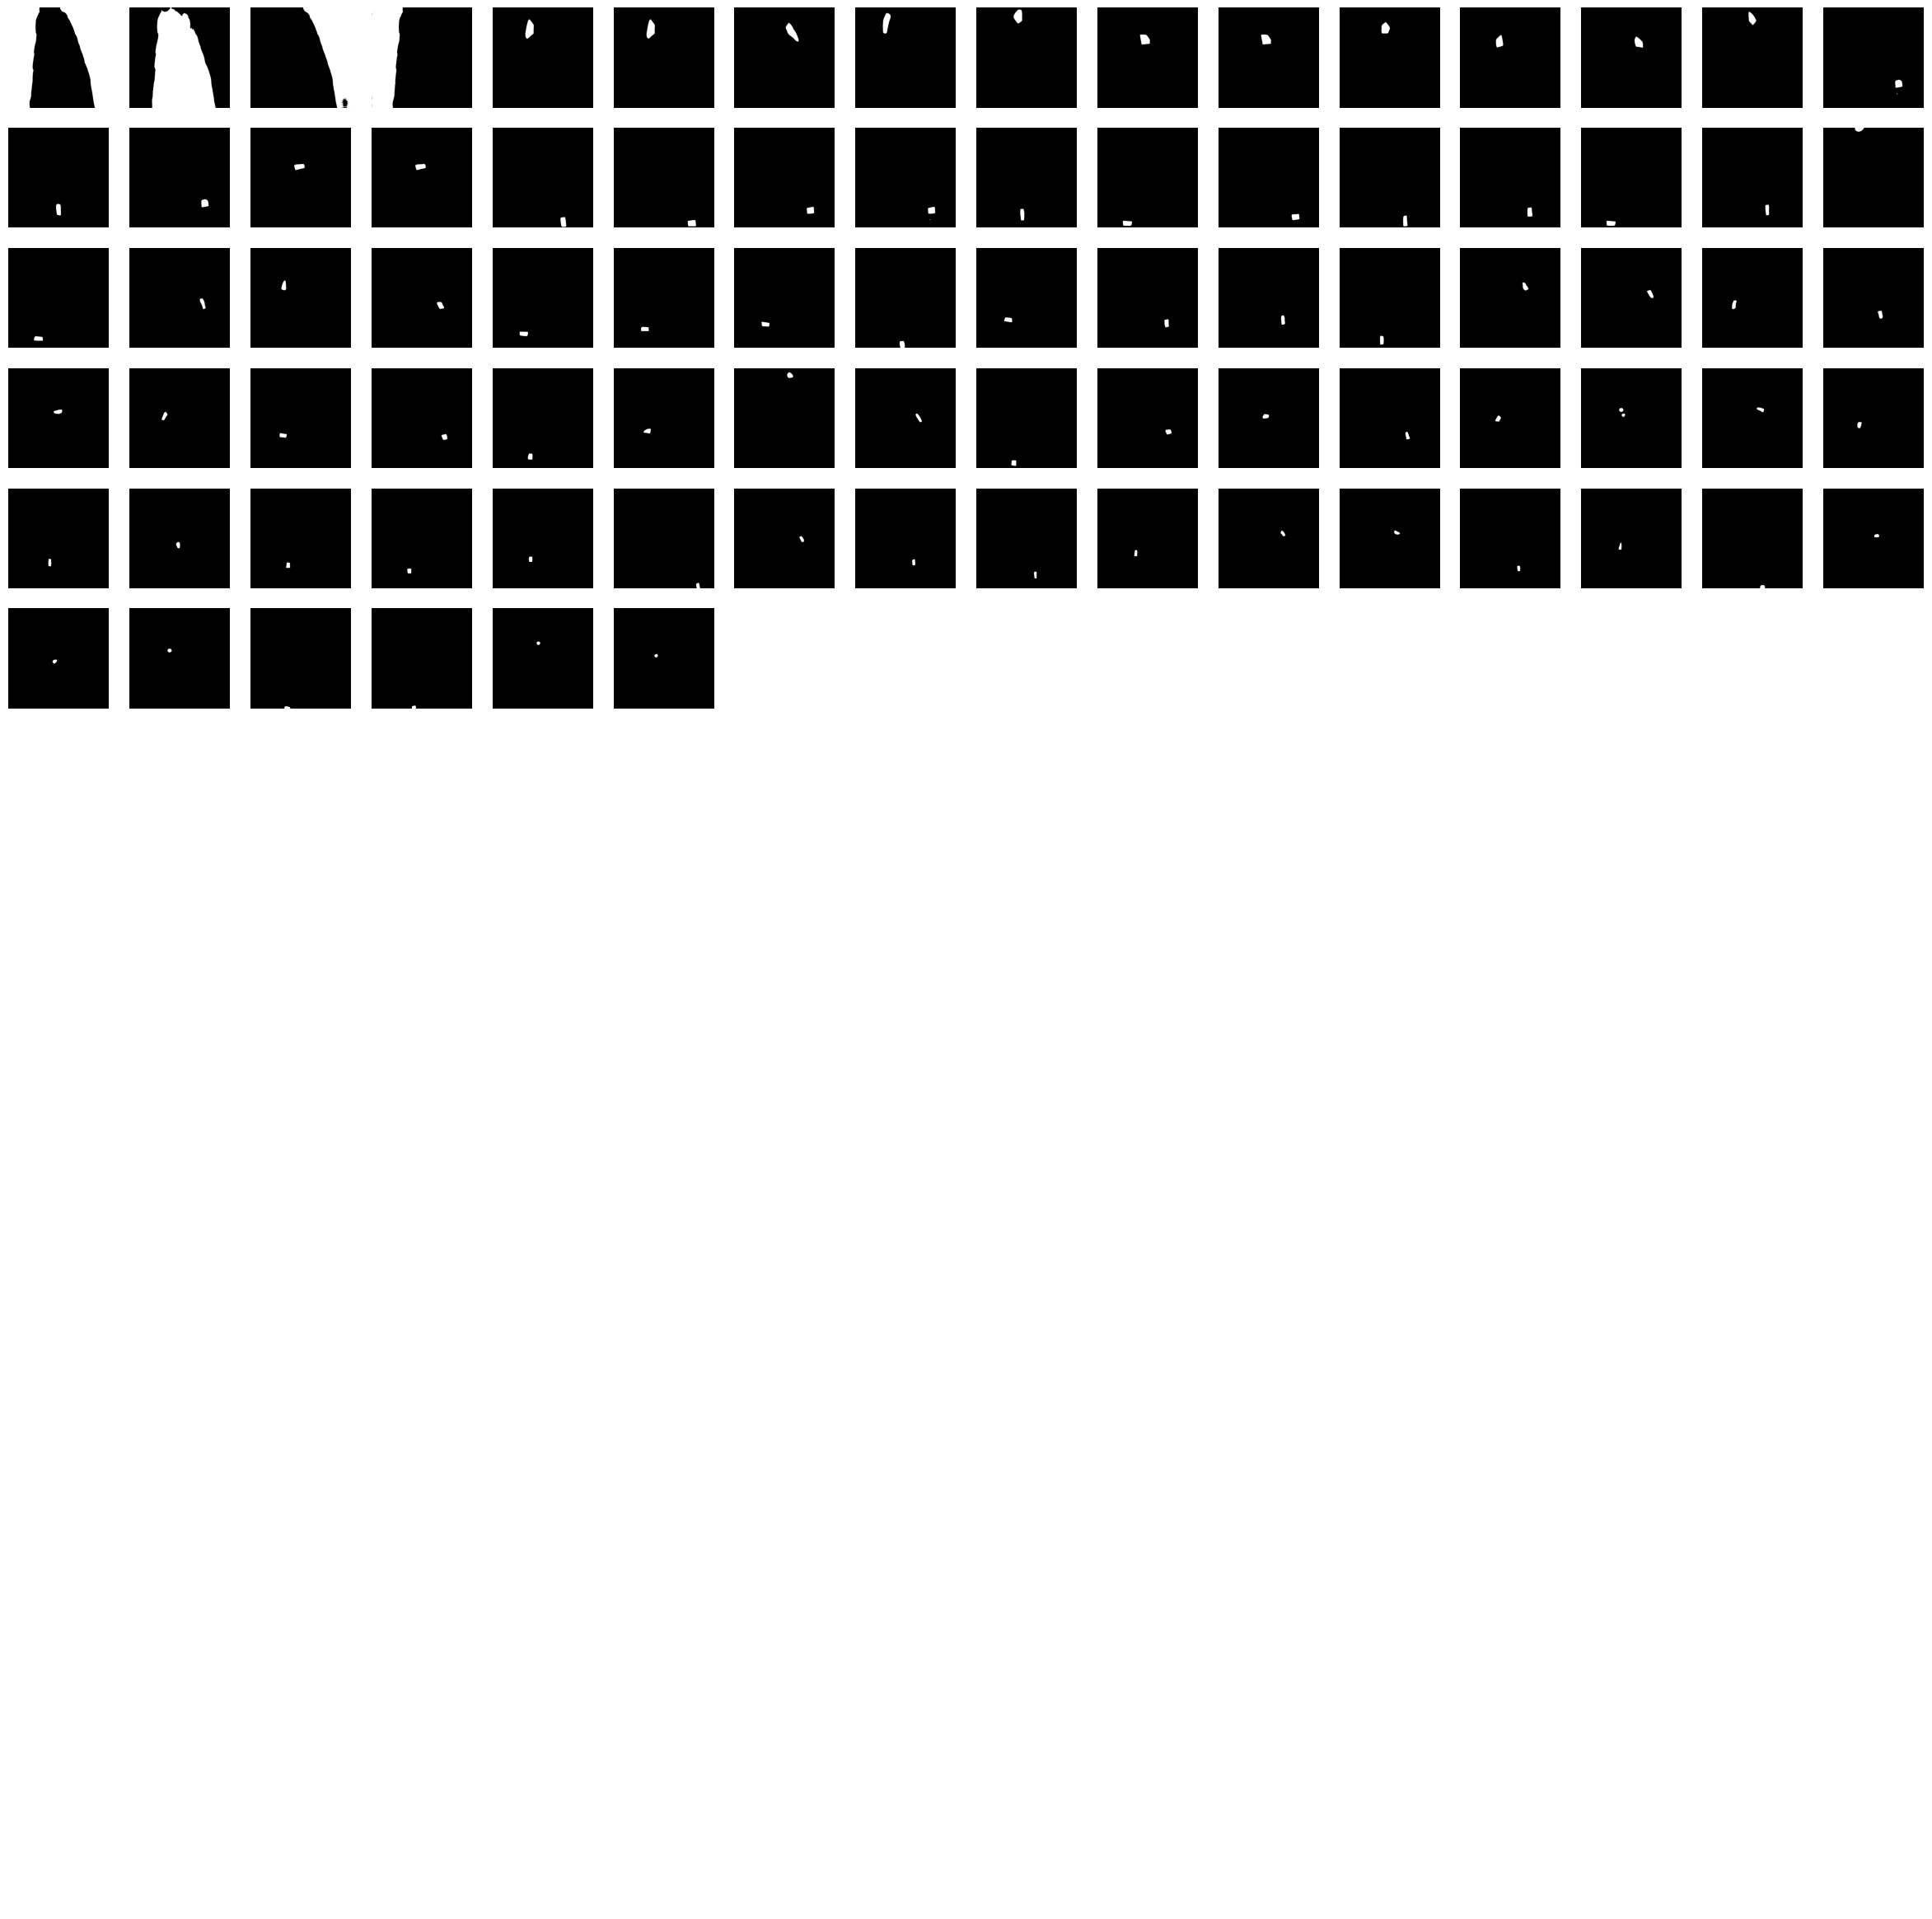

In [ ]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    # grid_size=(16, int(len(masks) / 16)),
    grid_size= (16, 16),
    size=(30, 30)
)

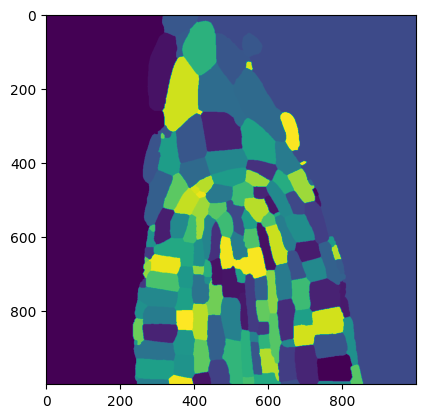

In [ ]:
from PIL import Image
import random
# image = Image.open("/content/drive/MyDrive/Imput Image and Segmented image/020422_At1_7d_long_meristem_CW_graystack8bit_predictions_multicut.tiff")
image2 = io.imread("/content/net_6_zStack_predictions_multicut.tiff")
# image = Image.open("/content/drive/MyDrive/Imput Image and Segmented image/032823_Es_root_tip3_8bit_C=0_predictions_multicut.tiff")
colorMatrix = {}
colorList = []
colors = range(1, 500000, 100) # 25, 50, 100
oldColor = 0
seg_img = []
for img in image2:
  for i in range(len(img)):
    for j in range(len(img)):
      g = img[i,j]
      if g == 1:
        img[i,j] = 255
      elif g not in colorMatrix:
        newColor = colors[random.randint(0, len(colors) - 1)]
        while(newColor in colorList or (newColor < (oldColor + 100) and newColor > (oldColor - 250))):
          newColor = colors[random.randint(0, len(colors) - 1)] + 100
        colorList.append(newColor)
        colorMatrix[g] = newColor
        img[i,j] = newColor
        oldColor = newColor
      else:
        img[i,j] = colorMatrix[g]
        oldColor = colorMatrix[g]
  seg_img.append(img)
plt.imshow(seg_img[7])

In [ ]:
unique_labels = np.unique(image2[0])
masks2 = []
for label in unique_labels:
    # Create a mask for the current label
    mask1 = (image2[0] == label).astype(np.uint8)
    masks2.append(mask1)


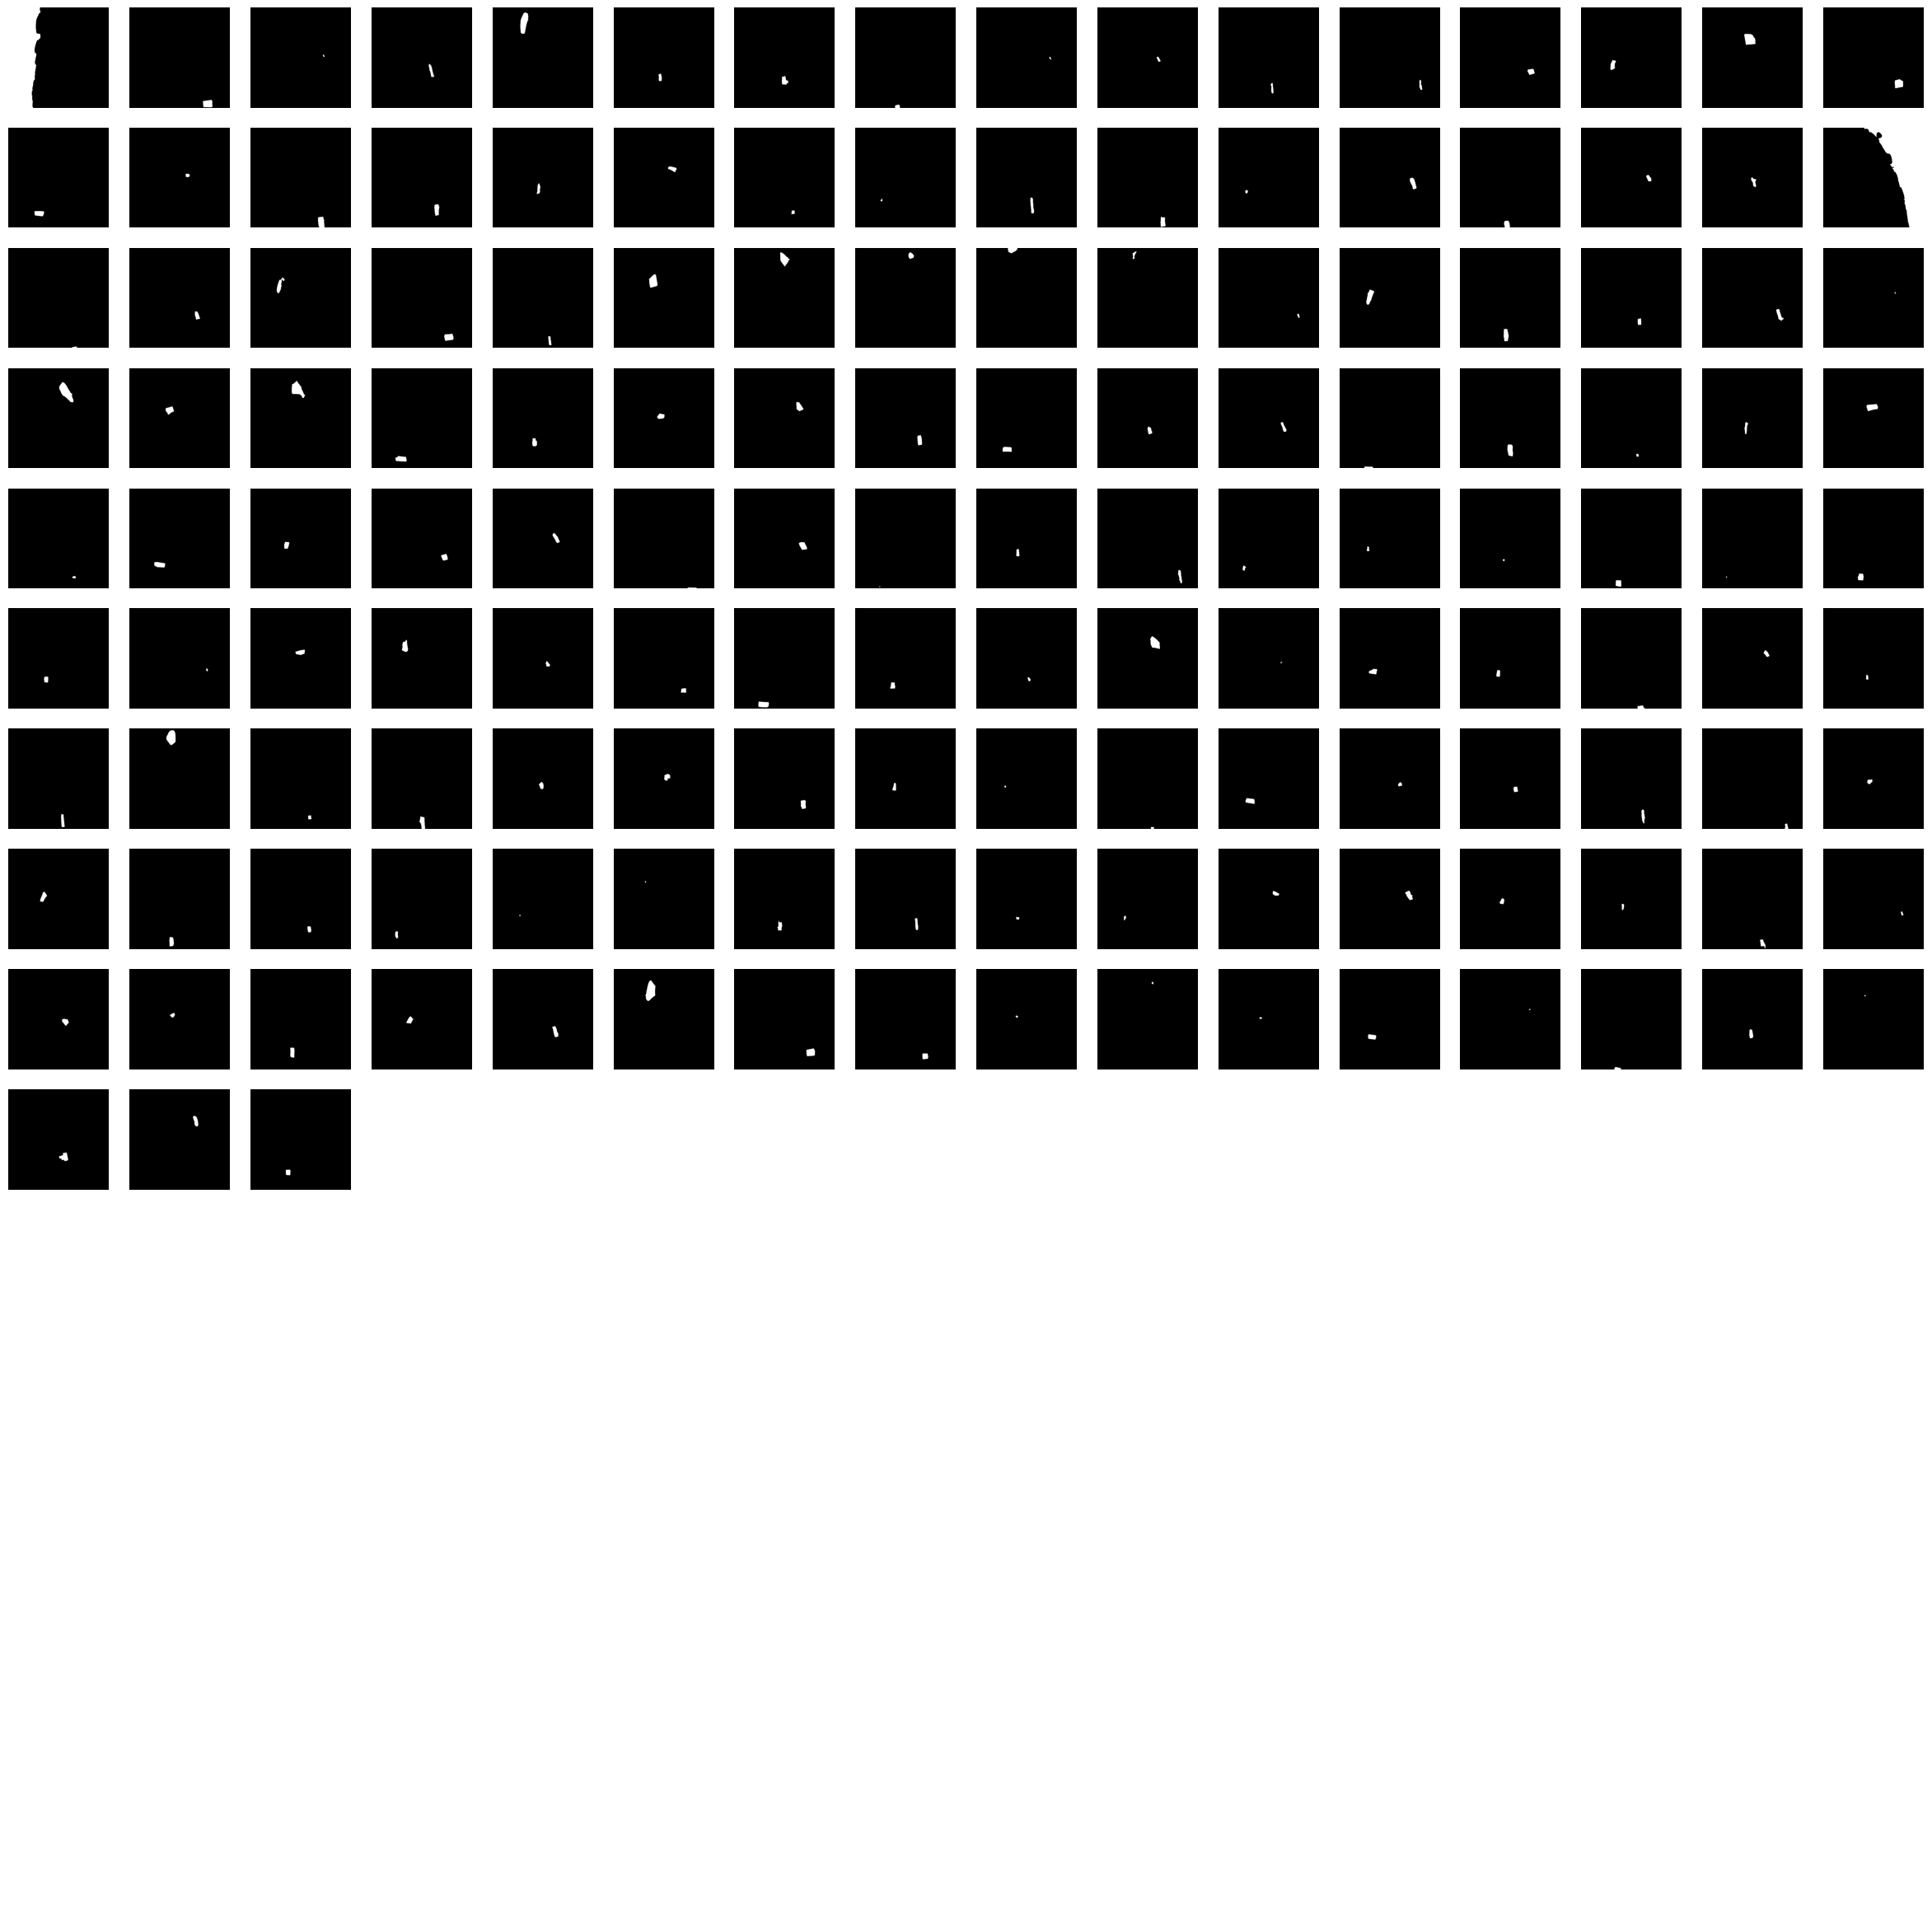

In [ ]:
sv.plot_images_grid(
    images=masks2,
    # grid_size=(16, int(len(masks) / 16)),
    grid_size= (16, 16),
    size=(30, 30)
)

In [ ]:
# SAM based mapping
import numpy as np
from scipy.optimize import linear_sum_assignment

def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

iou_matrix_sam = np.zeros((len(masks), len(masks2)))

for i, pred_mask in enumerate(masks):
    for j, gt_mask in enumerate(masks2):
        iou_matrix_sam[i, j] = calculate_iou(pred_mask, gt_mask)

cost_matrix = -iou_matrix_sam
mask_mapping_sam = {}
for i in range(len(masks)):
  max_index = np.unravel_index(np.argmax(iou_matrix_sam[i]), iou_matrix_sam[i].shape)
  mask_mapping_sam[i] = max_index[0]
# row_ind, col_ind = linear_sum_assignment(cost_matrix)

# # Create a mapping of ground truth mask indices to predicted mask indices
# mask_mapping = {i: j for i, j in zip(row_ind, col_ind)}

In [ ]:
matched_iou_scores_sam = []

for pred_index in mask_mapping_sam.keys():
    iou_score = iou_matrix_sam[pred_index, mask_mapping_sam[pred_index]]
    matched_iou_scores_sam.append(iou_score)

In [ ]:
# PS based mapping
import numpy as np
from scipy.optimize import linear_sum_assignment

def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

iou_matrix_ps = np.zeros((len(masks2), len(masks)))

for i, gt_mask in enumerate(masks2):
    for j, pred_mask in enumerate(masks):
        iou_matrix_ps[i, j] = calculate_iou(pred_mask, gt_mask)

# Apply the Hungarian algorithm to maximize total IoU
cost_matrix = -iou_matrix_ps
mask_mapping_ps = {}
for i in range(len(masks2)):
  max_index = np.unravel_index(np.argmax(iou_matrix_ps[i]), iou_matrix_ps[i].shape)
  mask_mapping_ps[i] = max_index[0]
# row_ind, col_ind = linear_sum_assignment(cost_matrix)

# # Create a mapping of ground truth mask indices to predicted mask indices
# mask_mapping = {i: j for i, j in zip(row_ind, col_ind)}

In [ ]:
matched_iou_scores_ps = []

for pred_index in mask_mapping_ps.keys():
    iou_score = iou_matrix_ps[pred_index, mask_mapping_ps[pred_index]]
    matched_iou_scores_ps.append(iou_score)

In [ ]:
print(np.mean(matched_iou_scores_sam))
print(np.mean(matched_iou_scores_ps))

0.7195471610583176
0.393091053497877


In [ ]:
mappings_final = {}
for k, v in mask_mapping_sam.items():
  if mask_mapping_ps[v] == k:
      mappings_final[k] = v

In [ ]:
matched_iou_scores_fin = []

for pred_index in mappings_final.keys():
    iou_score = iou_matrix_sam[pred_index, mappings_final[pred_index]]
    matched_iou_scores_fin.append(iou_score)

In [ ]:
np.mean(matched_iou_scores_fin)

0.7412324251809899

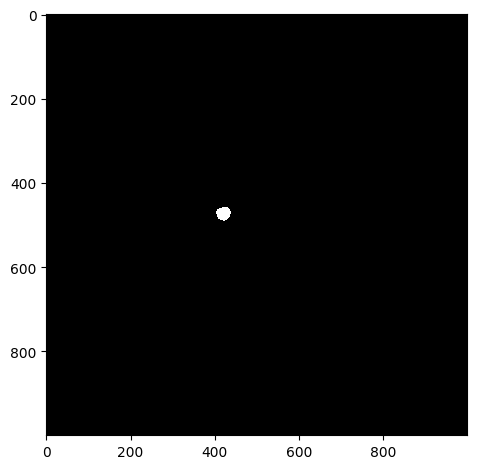

In [ ]:
# io.imshow(masks[85])

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


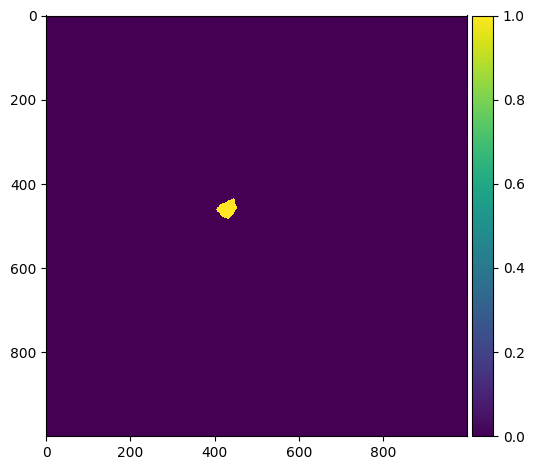

In [ ]:
# io.imshow(masks2[129])

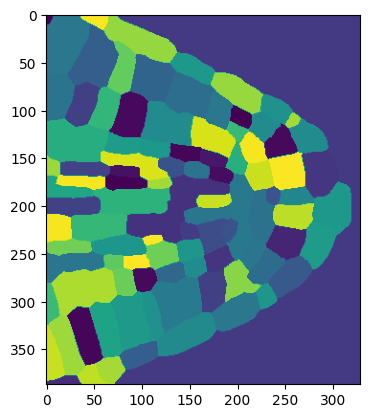

In [ ]:
from PIL import Image
import random
# image = Image.open("/content/drive/MyDrive/Imput Image and Segmented image/020422_At1_7d_long_meristem_CW_graystack8bit_predictions_multicut.tiff")
image2 = io.imread("/content/net_15_zStack_predictions_multicut.tiff")
# image = Image.open("/content/drive/MyDrive/Imput Image and Segmented image/032823_Es_root_tip3_8bit_C=0_predictions_multicut.tiff")
colorMatrix = {}
colorList = []
colors = range(1, 500000, 100) # 25, 50, 100
oldColor = 0
seg_img = []
for img in image2:
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      g = img[i,j]
      if g == 1:
        img[i,j] = 255
      elif g not in colorMatrix:
        newColor = colors[random.randint(0, len(colors) - 1)]
        while(newColor in colorList or (newColor < (oldColor + 100) and newColor > (oldColor - 250))):
          newColor = colors[random.randint(0, len(colors) - 1)] + 100
        colorList.append(newColor)
        colorMatrix[g] = newColor
        img[i,j] = newColor
        oldColor = newColor
      else:
        img[i,j] = colorMatrix[g]
        oldColor = colorMatrix[g]
  seg_img.append(img)
plt.imshow(seg_img[7])

In [ ]:
!pip install nbconvert

In [ ]:
!apt-get -qq install texlive texlive-xetex texlive-latex-extra pandoc
!pip install --quiet pypandoc

Extracting templates from packages: 100%
Preconfiguring packages ...
Selecting previously unselected package fonts-droid-fallback.
(Reading database ... 120895 files and directories currently installed.)
Preparing to unpack .../00-fonts-droid-fallback_1%3a6.0.1r16-1.1build1_all.deb ...
Unpacking fonts-droid-fallback (1:6.0.1r16-1.1build1) ...
Selecting previously unselected package fonts-lato.
Preparing to unpack .../01-fonts-lato_2.0-2.1_all.deb ...
Unpacking fonts-lato (2.0-2.1) ...
Selecting previously unselected package poppler-data.
Preparing to unpack .../02-poppler-data_0.4.11-1_all.deb ...
Unpacking poppler-data (0.4.11-1) ...
Selecting previously unselected package tex-common.
Preparing to unpack .../03-tex-common_6.17_all.deb ...
Unpacking tex-common (6.17) ...
Selecting previously unselected package fonts-urw-base35.
Preparing to unpack .../04-fonts-urw-base35_20200910-1_all.deb ...
Unpacking fonts-urw-base35 (20200910-1) ...
Selecting previously unselected package libgs9-co

In [ ]:
!jupyter nbconvert --to PDF "/content/drive/MyDrive/Colab Notebooks/SAM_confocal.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/SAM_confocal.ipynb to PDF
[NbConvertApp] Support files will be in SAM_confocal_files/
[NbConvertApp] Making directory ./SAM_confocal_files
[NbConvertApp] Making directory ./SAM_confocal_files
[NbConvertApp] Making directory ./SAM_confocal_files
[NbConvertApp] Making directory ./SAM_confocal_files
[NbConvertApp] Making directory ./SAM_confocal_files
[NbConvertApp] Making directory ./SAM_confocal_files
[NbConvertApp] Making directory ./SAM_confocal_files
[NbConvertApp] Making directory ./SAM_confocal_files
[NbConvertApp] Making directory ./SAM_confocal_files
[NbConvertApp] Making directory ./SAM_confocal_files
[NbConvertApp] Making directory ./SAM_confocal_files
[NbConvertApp] Making directory ./SAM_confocal_files
[NbConvertApp] Making directory ./SAM_confocal_files
[NbConvertApp] Making directory ./SAM_confocal_files
[NbConvertApp] Making directory ./SAM_confocal_files
[NbConvertApp] Making directory ./SAM_confoca